In [8]:
# for mounting drive with google colabs
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install -q keras

In [11]:
!ls

datalab  drive


In [0]:
import sys
import time 
import os
import cv2
import datetime
from PIL import Image
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
% matplotlib inline

# Reading data

In [0]:
data = pd.read_csv('drive/fer2013.csv')

In [14]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [0]:
data_train = data.loc[data['Usage']=='Training']
public_test = data.loc[data['Usage']=='PublicTest']
private_test = data.loc[data['Usage']=='PrivateTest']

In [16]:
data_train.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [17]:
public_test.head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [18]:
private_test.head()

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest


In [19]:
data_train.describe()

,emotion
count,28709.000000
mean,3.317427
std,1.876632
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [0]:
k = data_train.iloc[1,1]

In [21]:
len(k.split())

2304

# Data Preprocessing
## Transforming csv to understandable image data

In [0]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)
public_test = shuffle(public_test)
private_test = shuffle(private_test)

In [23]:
train = np.array(data_train.iloc[:,1])
validation = np.array(private_test.iloc[:,1])
test = np.array(public_test.iloc[:,1])
print(train.shape, test.shape, validation.shape)

(28709,) (3589,) (3589,)


In [0]:
train = train.reshape(28709,1)
test = test.reshape(3589,1)
validation = validation.reshape(3589,1)
X_train_flip = list()

In [25]:
train.shape

(28709, 1)

In [0]:
def data_augmentation(img):
  img = cv2.flip(img.reshape(48,48), 1)
  return np.array(img.reshape(48,48,1)).astype(np.float32)

In [0]:
def reform_data_aug(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48, 1)

  X_train_flip.append(data_augmentation(t3))
  return t3

In [0]:
def reform_data(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48, 1)
  return t3

In [0]:
X_train_1 = np.apply_along_axis(reform_data_aug, 1, train)
X_test = np.apply_along_axis(reform_data, 1, test)
X_validation = np.apply_along_axis(reform_data, 1, validation)

In [30]:
np.array(X_train_flip).shape

(28709, 48, 48, 1)

In [31]:
X_train = np.array(list(X_train_1) + X_train_flip)
print(X_train.shape)

(57418, 48, 48, 1)


In [32]:
print(X_train.shape, X_test.shape, X_validation.shape)

(57418, 48, 48, 1) (3589, 48, 48, 1) (3589, 48, 48, 1)


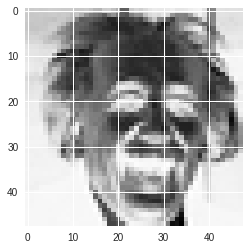

In [33]:
# Sample image
plt.imshow(X_train[0].reshape(48,48))

### Normalization 

In [0]:
X_train = X_train/255
X_test = X_test/255
X_validation = X_validation/255

### One Hot Encoding

In [0]:
Y_train = data_train['emotion']
Y_test = public_test['emotion']
Y_validation = private_test['emotion']

In [36]:
print(Y_train.shape, Y_test.shape, Y_validation.shape)

(28709,) (3589,) (3589,)


In [0]:
def onehot(Y, C):
  Y = np.eye(C)[Y].T
  return Y

In [38]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [0]:
Y_test = onehot(Y_test, 7).T
Y_train = onehot(Y_train, 7).T
Y_valid = onehot(Y_validation, 7).T

In [40]:
Y_train.shape

(28709, 7)

In [0]:
Y_train = np.array(list(Y_train) + list(Y_train))

In [42]:
Y_train.shape

(57418, 7)

In [0]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=2)

In [44]:
print(X_validation.shape, Y_valid.shape)

(3589, 48, 48, 1) (3589, 7)


In [0]:
# Clear memory
del data
del data_train
del public_test
del private_test
del Y_validation

## CNN Models
Taking 3 - 4 models for ensemble voting

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, Adamax
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.regularizers import l2

### 1-Basic 5 layer model

In [0]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
input_shape = (48, 48, 1)

In [0]:
def Model1(input_shape=(48,48,1)):
  model = Sequential()
  
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=input_shape, data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_labels, activation='softmax'))
  return model

In [40]:
model1 = Model1()
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)       512       
__________

In [0]:
model1.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model1.load_weights("drive/face_expr_model1.h5")

In [47]:
model1.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=300,
          verbose=1,
          validation_data=(X_validation, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, tensorboard, checkpointer])

Train on 57418 samples, validate on 3589 samples
Epoch 1/300
43840/57418 [=====================>........] - ETA: 27s - loss: 0.3085 - acc: 0.8987

57418/57418 [==============================] - 120s 2ms/step - loss: 0.3182 - acc: 0.8963 - val_loss: 1.2731 - val_acc: 0.6709

Epoch 00001: val_loss improved from inf to 1.27313, saving model to /drive
Epoch 2/300
17408/57418 [========>.....................] - ETA: 1:19 - loss: 0.3355 - acc: 0.8915

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3466 - acc: 0.8868 - val_loss: 1.2974 - val_acc: 0.6489

Epoch 00002: val_loss did not improve from 1.27313
Epoch 3/300
10944/57418 [====>.........................] - ETA: 1:32 - loss: 0.3368 - acc: 0.8865

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3456 - acc: 0.8844 - val_loss: 1.3302 - val_acc: 0.6559

Epoch 00003: val_loss did not improve from 1.27313
Epoch 4/300
 8896/57418 [===>..........................] - ETA: 1:36 - loss: 0.3441 - acc: 0.8853

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3552 - acc: 0.8833 - val_loss: 1.2190 - val_acc: 0.6620

Epoch 00004: val_loss improved from 1.27313 to 1.21900, saving model to /drive
Epoch 5/300
 7488/57418 [==>...........................] - ETA: 1:40 - loss: 0.3480 - acc: 0.8868

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3649 - acc: 0.8793 - val_loss: 1.3062 - val_acc: 0.6601

Epoch 00005: val_loss did not improve from 1.21900
Epoch 6/300
 7872/57418 [===>..........................] - ETA: 1:39 - loss: 0.4933 - acc: 0.8368

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3878 - acc: 0.8713 - val_loss: 1.2542 - val_acc: 0.6704

Epoch 00006: val_loss did not improve from 1.21900
Epoch 7/300
 8000/57418 [===>..........................] - ETA: 1:38 - loss: 0.3756 - acc: 0.8776

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3630 - acc: 0.8800 - val_loss: 1.3386 - val_acc: 0.6592

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00007: val_loss did not improve from 1.21900
Epoch 8/300
 6144/57418 [==>...........................] - ETA: 1:42 - loss: 0.4050 - acc: 0.8674

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3581 - acc: 0.8812 - val_loss: 1.2405 - val_acc: 0.6634

Epoch 00008: val_loss did not improve from 1.21900
Epoch 9/300
 7424/57418 [==>...........................] - ETA: 1:40 - loss: 0.3625 - acc: 0.8836

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3454 - acc: 0.8872 - val_loss: 1.2977 - val_acc: 0.6565

Epoch 00009: val_loss did not improve from 1.21900
Epoch 10/300
 7808/57418 [===>..........................] - ETA: 1:39 - loss: 0.3410 - acc: 0.8922

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3412 - acc: 0.8890 - val_loss: 1.3018 - val_acc: 0.6581

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00010: val_loss did not improve from 1.21900
Epoch 11/300
 6144/57418 [==>...........................] - ETA: 1:42 - loss: 0.3206 - acc: 0.8910

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3303 - acc: 0.8903 - val_loss: 1.2574 - val_acc: 0.6665

Epoch 00011: val_loss did not improve from 1.21900
Epoch 12/300
 7424/57418 [==>...........................] - ETA: 1:40 - loss: 0.3074 - acc: 0.8994

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3177 - acc: 0.8942 - val_loss: 1.3263 - val_acc: 0.6701

Epoch 00012: val_loss did not improve from 1.21900
Epoch 00012: early stopping


In [0]:
model1.save_weights("drive/face_expr_model1.h5")

In [39]:
model1.evaluate(X_test, Y_test, batch_size=batch_size)

3589/3589 [==============================] - 4s 1ms/step


[1.3717110114995734, 0.670660351081026]

In [0]:
model1_2 = Model1()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(horizontal_flip=True,
                        vertical_flip=True)
train_generator_1 = gen.flow(X_train, Y_train, batch_size=batch_size)
 
model1_2.compile(loss=categorical_crossentropy
, optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
, metrics=['accuracy']
)
 

In [0]:
model1_2.load_weights("drive/face_expr_model1_2.h5")

In [128]:
model1_2.fit_generator(train_generator_1, steps_per_epoch=50, epochs=300)

Epoch 1/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7288 - acc: 0.7403
Epoch 2/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7266 - acc: 0.7422
Epoch 3/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7050 - acc: 0.7494
Epoch 4/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7082 - acc: 0.7441
Epoch 5/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6933 - acc: 0.7562
Epoch 6/300
49/50 [============================>.] - ETA: 0s - loss: 0.7191 - acc: 0.7392

50/50 [==============================] - 6s 130ms/step - loss: 0.7149 - acc: 0.7419
Epoch 7/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7051 - acc: 0.7478
Epoch 8/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7328 - acc: 0.7381
Epoch 9/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7043 - acc: 0.7562
Epoch 10/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7610 - acc: 0.7316
Epoch 11/300
29/50 [================>.............] - ETA: 2s - loss: 0.7043 - acc: 0.7570

50/50 [==============================] - 7s 131ms/step - loss: 0.7217 - acc: 0.7519
Epoch 12/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7337 - acc: 0.7519
Epoch 13/300
50/50 [==============================] - 7s 131ms/step - loss: 0.6854 - acc: 0.7556
Epoch 14/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7102 - acc: 0.7612
Epoch 15/300
50/50 [==============================] - 7s 131ms/step - loss: 0.6921 - acc: 0.7603
Epoch 16/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7817 - acc: 0.7244
Epoch 17/300
 6/50 [==>...........................] - ETA: 5s - loss: 0.6949 - acc: 0.7708

50/50 [==============================] - 6s 130ms/step - loss: 0.6954 - acc: 0.7550
Epoch 18/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7357 - acc: 0.7428
Epoch 19/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6979 - acc: 0.7431
Epoch 20/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7041 - acc: 0.7516
Epoch 21/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7343 - acc: 0.7447
Epoch 22/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7057 - acc: 0.7569
Epoch 23/300
 3/50 [>.............................] - ETA: 6s - loss: 0.5399 - acc: 0.8229

50/50 [==============================] - 6s 130ms/step - loss: 0.7134 - acc: 0.7491
Epoch 24/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7311 - acc: 0.7453
Epoch 25/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7004 - acc: 0.7528
Epoch 26/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6944 - acc: 0.7556
Epoch 27/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6915 - acc: 0.7525
Epoch 28/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7341 - acc: 0.7394
Epoch 29/300
 3/50 [>.............................] - ETA: 6s - loss: 0.7076 - acc: 0.7396

50/50 [==============================] - 6s 130ms/step - loss: 0.7019 - acc: 0.7550
Epoch 30/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7397 - acc: 0.7378
Epoch 31/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7214 - acc: 0.7419
Epoch 32/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6928 - acc: 0.7584
Epoch 33/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7086 - acc: 0.7509
Epoch 34/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6945 - acc: 0.7537
Epoch 35/300
 3/50 [>.............................] - ETA: 6s - loss: 0.5888 - acc: 0.7969

50/50 [==============================] - 6s 130ms/step - loss: 0.7198 - acc: 0.7403
Epoch 36/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7187 - acc: 0.7438
Epoch 37/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7097 - acc: 0.7522
Epoch 38/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7180 - acc: 0.7544
Epoch 39/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6946 - acc: 0.7553
Epoch 40/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6936 - acc: 0.7606
Epoch 41/300
 3/50 [>.............................] - ETA: 6s - loss: 0.7224 - acc: 0.7344

50/50 [==============================] - 6s 129ms/step - loss: 0.7047 - acc: 0.7419
Epoch 42/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7134 - acc: 0.7556
Epoch 43/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7018 - acc: 0.7572
Epoch 44/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7245 - acc: 0.7438
Epoch 45/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7308 - acc: 0.7466
Epoch 46/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7115 - acc: 0.7441
Epoch 47/300
 3/50 [>.............................] - ETA: 6s - loss: 0.6285 - acc: 0.7812

50/50 [==============================] - 6s 129ms/step - loss: 0.6955 - acc: 0.7619
Epoch 48/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7203 - acc: 0.7388
Epoch 49/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7143 - acc: 0.7574
Epoch 50/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7226 - acc: 0.7509
Epoch 51/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7088 - acc: 0.7525
Epoch 52/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7260 - acc: 0.7344
Epoch 53/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6845 - acc: 0.7578

50/50 [==============================] - 6s 130ms/step - loss: 0.7352 - acc: 0.7425
Epoch 54/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7083 - acc: 0.7516
Epoch 55/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6926 - acc: 0.7600
Epoch 56/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7096 - acc: 0.7516
Epoch 57/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7233 - acc: 0.7409
Epoch 58/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7180 - acc: 0.7481
Epoch 59/300
 3/50 [>.............................] - ETA: 6s - loss: 0.6166 - acc: 0.7604

50/50 [==============================] - 6s 129ms/step - loss: 0.6780 - acc: 0.7550
Epoch 60/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7098 - acc: 0.7581
Epoch 61/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6893 - acc: 0.7572
Epoch 62/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6828 - acc: 0.7575
Epoch 63/300
50/50 [==============================] - 6s 128ms/step - loss: 0.7129 - acc: 0.7470
Epoch 64/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7035 - acc: 0.7519
Epoch 65/300
 3/50 [>.............................] - ETA: 6s - loss: 0.7209 - acc: 0.7500

50/50 [==============================] - 6s 130ms/step - loss: 0.6989 - acc: 0.7456
Epoch 66/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6935 - acc: 0.7641
Epoch 67/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6933 - acc: 0.7531
Epoch 68/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7384 - acc: 0.7397
Epoch 69/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7125 - acc: 0.7447
Epoch 70/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7259 - acc: 0.7325
Epoch 71/300
 3/50 [>.............................] - ETA: 5s - loss: 0.8495 - acc: 0.6927

50/50 [==============================] - 6s 130ms/step - loss: 0.7092 - acc: 0.7456
Epoch 72/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6753 - acc: 0.7553
Epoch 73/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6994 - acc: 0.7522
Epoch 74/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6858 - acc: 0.7591
Epoch 75/300
50/50 [==============================] - 7s 131ms/step - loss: 0.6835 - acc: 0.7547
Epoch 76/300
50/50 [==============================] - 7s 131ms/step - loss: 0.6957 - acc: 0.7522
Epoch 77/300
 3/50 [>.............................] - ETA: 6s - loss: 0.6618 - acc: 0.7760

50/50 [==============================] - 6s 129ms/step - loss: 0.7262 - acc: 0.7408
Epoch 78/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7021 - acc: 0.7466
Epoch 79/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7176 - acc: 0.7444
Epoch 80/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7125 - acc: 0.7512
Epoch 81/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7316 - acc: 0.7450
Epoch 82/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7187 - acc: 0.7438
Epoch 83/300
 3/50 [>.............................] - ETA: 5s - loss: 0.6543 - acc: 0.7604

50/50 [==============================] - 6s 130ms/step - loss: 0.6898 - acc: 0.7659
Epoch 84/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6918 - acc: 0.7550
Epoch 85/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7479 - acc: 0.7388
Epoch 86/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6934 - acc: 0.7575
Epoch 87/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7085 - acc: 0.7544
Epoch 88/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6984 - acc: 0.7503
Epoch 89/300
 3/50 [>.............................] - ETA: 5s - loss: 0.5903 - acc: 0.7865

50/50 [==============================] - 6s 128ms/step - loss: 0.7339 - acc: 0.7322
Epoch 90/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7216 - acc: 0.7556
Epoch 91/300
50/50 [==============================] - 6s 128ms/step - loss: 0.7083 - acc: 0.7488
Epoch 92/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7015 - acc: 0.7441
Epoch 93/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6746 - acc: 0.7469
Epoch 94/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6822 - acc: 0.7625
Epoch 95/300
 3/50 [>.............................] - ETA: 6s - loss: 0.7391 - acc: 0.7240

50/50 [==============================] - 6s 129ms/step - loss: 0.6972 - acc: 0.7478
Epoch 96/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6983 - acc: 0.7506
Epoch 97/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7107 - acc: 0.7534
Epoch 98/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7015 - acc: 0.7406
Epoch 99/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7065 - acc: 0.7544
Epoch 100/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7067 - acc: 0.7425
Epoch 101/300
 3/50 [>.............................] - ETA: 6s - loss: 0.6428 - acc: 0.7760

50/50 [==============================] - 6s 129ms/step - loss: 0.6836 - acc: 0.7619
Epoch 102/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6800 - acc: 0.7594
Epoch 103/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6816 - acc: 0.7663
Epoch 104/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6873 - acc: 0.7600
Epoch 105/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7099 - acc: 0.7531
Epoch 106/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6757 - acc: 0.7497
Epoch 107/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7980 - acc: 0.7578

50/50 [==============================] - 6s 129ms/step - loss: 0.6954 - acc: 0.7572
Epoch 108/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7138 - acc: 0.7531
Epoch 109/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6790 - acc: 0.7566
Epoch 110/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7008 - acc: 0.7506
Epoch 111/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7284 - acc: 0.7403
Epoch 112/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6934 - acc: 0.7606
Epoch 113/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6570 - acc: 0.7656

50/50 [==============================] - 7s 130ms/step - loss: 0.7090 - acc: 0.7497
Epoch 114/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7105 - acc: 0.7566
Epoch 115/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6978 - acc: 0.7537
Epoch 116/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6810 - acc: 0.7669
Epoch 117/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6893 - acc: 0.7597
Epoch 118/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6860 - acc: 0.7641
Epoch 119/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6612 - acc: 0.7500

50/50 [==============================] - 6s 129ms/step - loss: 0.7135 - acc: 0.7458
Epoch 120/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6788 - acc: 0.7556
Epoch 121/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7012 - acc: 0.7556
Epoch 122/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7269 - acc: 0.7453
Epoch 123/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6911 - acc: 0.7566
Epoch 124/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7096 - acc: 0.7503
Epoch 125/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7765 - acc: 0.7812

50/50 [==============================] - 6s 129ms/step - loss: 0.6935 - acc: 0.7566
Epoch 126/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7087 - acc: 0.7503
Epoch 127/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6724 - acc: 0.7678
Epoch 128/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6781 - acc: 0.7641
Epoch 129/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7074 - acc: 0.7531
Epoch 130/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6803 - acc: 0.7575
Epoch 131/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6496 - acc: 0.7344

50/50 [==============================] - 6s 130ms/step - loss: 0.6817 - acc: 0.7547
Epoch 132/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6892 - acc: 0.7531
Epoch 133/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6998 - acc: 0.7622
Epoch 134/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6965 - acc: 0.7478
Epoch 135/300
50/50 [==============================] - 6s 128ms/step - loss: 0.7056 - acc: 0.7493
Epoch 136/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7066 - acc: 0.7488
Epoch 137/300
 2/50 [>.............................] - ETA: 6s - loss: 0.8224 - acc: 0.7344

50/50 [==============================] - 6s 129ms/step - loss: 0.6957 - acc: 0.7516
Epoch 138/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7069 - acc: 0.7503
Epoch 139/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6755 - acc: 0.7628
Epoch 140/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7167 - acc: 0.7488
Epoch 141/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7006 - acc: 0.7509
Epoch 142/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6831 - acc: 0.7603
Epoch 143/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6064 - acc: 0.7734

50/50 [==============================] - 6s 130ms/step - loss: 0.6514 - acc: 0.7762
Epoch 144/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7162 - acc: 0.7481
Epoch 145/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7063 - acc: 0.7478
Epoch 146/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6561 - acc: 0.7678
Epoch 147/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6936 - acc: 0.7584
Epoch 148/300
50/50 [==============================] - 6s 128ms/step - loss: 0.6927 - acc: 0.7578
Epoch 149/300
 2/50 [>.............................] - ETA: 6s - loss: 0.8255 - acc: 0.6953

50/50 [==============================] - 7s 130ms/step - loss: 0.7345 - acc: 0.7425
Epoch 150/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6935 - acc: 0.7581
Epoch 151/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6964 - acc: 0.7506
Epoch 152/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6714 - acc: 0.7628
Epoch 153/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6737 - acc: 0.7672
Epoch 154/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7234 - acc: 0.7412
Epoch 155/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7827 - acc: 0.7188

50/50 [==============================] - 6s 130ms/step - loss: 0.6878 - acc: 0.7556
Epoch 156/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6870 - acc: 0.7575
Epoch 157/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6966 - acc: 0.7516
Epoch 158/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6912 - acc: 0.7556
Epoch 159/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6946 - acc: 0.7516
Epoch 160/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7192 - acc: 0.7456
Epoch 161/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6234 - acc: 0.8047

50/50 [==============================] - 6s 130ms/step - loss: 0.6830 - acc: 0.7703
Epoch 162/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7104 - acc: 0.7494
Epoch 163/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6528 - acc: 0.7747
Epoch 164/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7057 - acc: 0.7537
Epoch 165/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6817 - acc: 0.7647
Epoch 166/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6780 - acc: 0.7678
Epoch 167/300
 2/50 [>.............................] - ETA: 6s - loss: 0.5558 - acc: 0.8047

50/50 [==============================] - 7s 130ms/step - loss: 0.6593 - acc: 0.7741
Epoch 168/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6856 - acc: 0.7600
Epoch 169/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6852 - acc: 0.7578
Epoch 170/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6960 - acc: 0.7543
Epoch 171/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7078 - acc: 0.7672
Epoch 172/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7269 - acc: 0.7453
Epoch 173/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6959 - acc: 0.7656

50/50 [==============================] - 6s 130ms/step - loss: 0.6941 - acc: 0.7609
Epoch 174/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7056 - acc: 0.7581
Epoch 175/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6633 - acc: 0.7653
Epoch 176/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6944 - acc: 0.7544
Epoch 177/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6554 - acc: 0.7647
Epoch 178/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6990 - acc: 0.7491
Epoch 179/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6825 - acc: 0.7500

50/50 [==============================] - 6s 130ms/step - loss: 0.6879 - acc: 0.7678
Epoch 180/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7078 - acc: 0.7384
Epoch 181/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6752 - acc: 0.7578
Epoch 182/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6658 - acc: 0.7700
Epoch 183/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7266 - acc: 0.7422
Epoch 184/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7186 - acc: 0.7469
Epoch 185/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6405 - acc: 0.7812

50/50 [==============================] - 6s 130ms/step - loss: 0.6753 - acc: 0.7650
Epoch 186/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6480 - acc: 0.7788
Epoch 187/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6725 - acc: 0.7609
Epoch 188/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7031 - acc: 0.7534
Epoch 189/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7081 - acc: 0.7488
Epoch 190/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6674 - acc: 0.7594
Epoch 191/300
 2/50 [>.............................] - ETA: 6s - loss: 0.5037 - acc: 0.8203

50/50 [==============================] - 6s 130ms/step - loss: 0.6731 - acc: 0.7691
Epoch 192/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6840 - acc: 0.7594
Epoch 193/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6893 - acc: 0.7559
Epoch 194/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6775 - acc: 0.7631
Epoch 195/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6911 - acc: 0.7616
Epoch 196/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7178 - acc: 0.7412
Epoch 197/300
 2/50 [>.............................] - ETA: 6s - loss: 0.8722 - acc: 0.6797

50/50 [==============================] - 7s 131ms/step - loss: 0.7274 - acc: 0.7472
Epoch 198/300
50/50 [==============================] - 6s 128ms/step - loss: 0.6985 - acc: 0.7550
Epoch 199/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6965 - acc: 0.7591
Epoch 200/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6866 - acc: 0.7575
Epoch 201/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7016 - acc: 0.7619
Epoch 202/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6838 - acc: 0.7644
Epoch 203/300
 2/50 [>.............................] - ETA: 6s - loss: 0.5994 - acc: 0.8281

50/50 [==============================] - 6s 129ms/step - loss: 0.6688 - acc: 0.7562
Epoch 204/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6787 - acc: 0.7641
Epoch 205/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7234 - acc: 0.7544
Epoch 206/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6599 - acc: 0.7716
Epoch 207/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6733 - acc: 0.7675
Epoch 208/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6833 - acc: 0.7612
Epoch 209/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7058 - acc: 0.7344

50/50 [==============================] - 6s 130ms/step - loss: 0.7076 - acc: 0.7472
Epoch 210/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6898 - acc: 0.7625
Epoch 211/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6833 - acc: 0.7603
Epoch 212/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6694 - acc: 0.7628
Epoch 213/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7144 - acc: 0.7453
Epoch 214/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6885 - acc: 0.7662
Epoch 215/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6513 - acc: 0.7812

50/50 [==============================] - 6s 130ms/step - loss: 0.6545 - acc: 0.7706
Epoch 216/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7068 - acc: 0.7562
Epoch 217/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7128 - acc: 0.7472
Epoch 218/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6734 - acc: 0.7747
Epoch 219/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6947 - acc: 0.7600
Epoch 220/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6289 - acc: 0.7875
Epoch 221/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7123 - acc: 0.7422

50/50 [==============================] - 6s 129ms/step - loss: 0.6679 - acc: 0.7616
Epoch 222/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6995 - acc: 0.7562
Epoch 223/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7041 - acc: 0.7525
Epoch 224/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6915 - acc: 0.7522
Epoch 225/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7130 - acc: 0.7466
Epoch 226/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6733 - acc: 0.7616
Epoch 227/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7525 - acc: 0.7344

50/50 [==============================] - 6s 130ms/step - loss: 0.7018 - acc: 0.7553
Epoch 228/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7109 - acc: 0.7534
Epoch 229/300
50/50 [==============================] - 6s 128ms/step - loss: 0.6754 - acc: 0.7657
Epoch 230/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6808 - acc: 0.7628
Epoch 231/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7007 - acc: 0.7578
Epoch 232/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6730 - acc: 0.7572
Epoch 233/300
 2/50 [>.............................] - ETA: 6s - loss: 0.8166 - acc: 0.7344

50/50 [==============================] - 6s 130ms/step - loss: 0.6849 - acc: 0.7681
Epoch 234/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6998 - acc: 0.7547
Epoch 235/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6645 - acc: 0.7722
Epoch 236/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6670 - acc: 0.7638
Epoch 237/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6838 - acc: 0.7553
Epoch 238/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6803 - acc: 0.7584
Epoch 239/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6038 - acc: 0.8125

50/50 [==============================] - 6s 130ms/step - loss: 0.6581 - acc: 0.7537
Epoch 240/300
50/50 [==============================] - 7s 130ms/step - loss: 0.7015 - acc: 0.7594
Epoch 241/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6701 - acc: 0.7594
Epoch 242/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6823 - acc: 0.7619
Epoch 243/300
50/50 [==============================] - 7s 131ms/step - loss: 0.6657 - acc: 0.7666
Epoch 244/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7264 - acc: 0.7516
Epoch 245/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7990 - acc: 0.6875

50/50 [==============================] - 6s 128ms/step - loss: 0.6897 - acc: 0.7519
Epoch 246/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7163 - acc: 0.7591
Epoch 247/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6993 - acc: 0.7609
Epoch 248/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7250 - acc: 0.7456
Epoch 249/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6787 - acc: 0.7578
Epoch 250/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6633 - acc: 0.7656
Epoch 251/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7197 - acc: 0.7734

50/50 [==============================] - 7s 130ms/step - loss: 0.6924 - acc: 0.7581
Epoch 252/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6779 - acc: 0.7609
Epoch 253/300
50/50 [==============================] - 6s 128ms/step - loss: 0.6926 - acc: 0.7530
Epoch 254/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6500 - acc: 0.7719
Epoch 255/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6577 - acc: 0.7738
Epoch 256/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6960 - acc: 0.7506
Epoch 257/300
 2/50 [>.............................] - ETA: 6s - loss: 0.5554 - acc: 0.8281

50/50 [==============================] - 6s 129ms/step - loss: 0.6381 - acc: 0.7656
Epoch 258/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6951 - acc: 0.7494
Epoch 259/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6507 - acc: 0.7784
Epoch 260/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6915 - acc: 0.7506
Epoch 261/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6821 - acc: 0.7716
Epoch 262/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6626 - acc: 0.7638
Epoch 263/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7265 - acc: 0.7188

50/50 [==============================] - 7s 130ms/step - loss: 0.6690 - acc: 0.7625
Epoch 264/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6938 - acc: 0.7662
Epoch 265/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6949 - acc: 0.7619
Epoch 266/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6477 - acc: 0.7650
Epoch 267/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6829 - acc: 0.7672
Epoch 268/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6934 - acc: 0.7512
Epoch 269/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7118 - acc: 0.7422

50/50 [==============================] - 6s 129ms/step - loss: 0.6644 - acc: 0.7634
Epoch 270/300
50/50 [==============================] - 6s 130ms/step - loss: 0.7114 - acc: 0.7559
Epoch 271/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6573 - acc: 0.7753
Epoch 272/300
50/50 [==============================] - 6s 128ms/step - loss: 0.6602 - acc: 0.7697
Epoch 273/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6712 - acc: 0.7656
Epoch 274/300
50/50 [==============================] - 7s 131ms/step - loss: 0.6934 - acc: 0.7578
Epoch 275/300
 2/50 [>.............................] - ETA: 6s - loss: 0.5740 - acc: 0.7969

50/50 [==============================] - 7s 130ms/step - loss: 0.6730 - acc: 0.7687
Epoch 276/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6976 - acc: 0.7512
Epoch 277/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6871 - acc: 0.7609
Epoch 278/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6680 - acc: 0.7659
Epoch 279/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6573 - acc: 0.7712
Epoch 280/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6883 - acc: 0.7544
Epoch 281/300
 2/50 [>.............................] - ETA: 6s - loss: 0.5736 - acc: 0.8047

50/50 [==============================] - 7s 130ms/step - loss: 0.6510 - acc: 0.7656
Epoch 282/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6755 - acc: 0.7744
Epoch 283/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6563 - acc: 0.7747
Epoch 284/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6819 - acc: 0.7594
Epoch 285/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6759 - acc: 0.7594
Epoch 286/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6792 - acc: 0.7597
Epoch 287/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7662 - acc: 0.7734

50/50 [==============================] - 6s 130ms/step - loss: 0.6642 - acc: 0.7703
Epoch 288/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6751 - acc: 0.7684
Epoch 289/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6652 - acc: 0.7759
Epoch 290/300
50/50 [==============================] - 7s 130ms/step - loss: 0.6958 - acc: 0.7553
Epoch 291/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6535 - acc: 0.7675
Epoch 292/300
50/50 [==============================] - 6s 129ms/step - loss: 0.7036 - acc: 0.7588
Epoch 293/300
 2/50 [>.............................] - ETA: 6s - loss: 0.6579 - acc: 0.7422

50/50 [==============================] - 6s 130ms/step - loss: 0.6814 - acc: 0.7594
Epoch 294/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6749 - acc: 0.7597
Epoch 295/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6738 - acc: 0.7559
Epoch 296/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6391 - acc: 0.7744
Epoch 297/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6736 - acc: 0.7597
Epoch 298/300
50/50 [==============================] - 6s 129ms/step - loss: 0.6613 - acc: 0.7703
Epoch 299/300
 2/50 [>.............................] - ETA: 6s - loss: 0.7904 - acc: 0.7500

50/50 [==============================] - 6s 130ms/step - loss: 0.6898 - acc: 0.7625
Epoch 300/300
50/50 [==============================] - 6s 130ms/step - loss: 0.6731 - acc: 0.7566


In [0]:
model1_2.save("drive/face_expr_model1_2.h5")

In [43]:
model1_2.evaluate(X_validation, Y_valid, batch_size=64)

3589/3589 [==============================] - 3s 728us/step


[1.0729217210265047, 0.6595151853215964]

### 2- Model2 - https://arxiv.org/pdf/1706.01509

In [0]:
def Model2(input_shape=(48,48,1)):
  model = Sequential()
  model.add(Conv2D(10, (5,5), activation='relu', kernel_regularizer=l2(0.01), input_shape=input_shape))
  model.add(MaxPooling2D())
#   model.add(Dropout(0.5))
  model.add(Conv2D(10, (5,5), activation='relu'))
  model.add(MaxPooling2D())
#   model.add(Dropout(0.5))
  model.add(Conv2D(10, (3,3), activation='relu'))
  model.add(MaxPooling2D()) 
#   model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_labels, activation='softmax'))
  return model

# TODO - replace 

In [45]:
model2 = Model2()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 44, 44, 10)        260       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 10)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 18, 18, 10)        2510      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 9, 9, 10)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 10)          910       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 10)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 90)                0         
__________

In [0]:
lr_reducer2 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard2 = TensorBoard(log_dir='./logs')
early_stopper2 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer2 = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model2.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
model2.load_weights("drive/face_expr_model2.h5")

In [0]:
model2.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=500,
          verbose=1,
          validation_data=(X_validation, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer2, tensorboard2, checkpointer2])

Train on 57418 samples, validate on 3589 samples
Epoch 1/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0620 - acc: 0.5969 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00001: val_loss did not improve from 1.21309
Epoch 2/500
50816/57418 [=========================>....] - ETA: 1s - loss: 1.0611 - acc: 0.5987

57418/57418 [==============================] - 13s 221us/step - loss: 1.0620 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00002: val_loss did not improve from 1.21309
Epoch 3/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0606 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00003: val_loss did not improve from 1.21309
Epoch 4/500
18880/57418 [========>.....................] - ETA: 8s - loss: 1.0741 - acc: 0.5960

57418/57418 [==============================] - 13s 222us/step - loss: 1.0644 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.426607435297324e-12.

Epoch 00004: val_loss did not improve from 1.21309
Epoch 5/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00005: val_loss did not improve from 1.21309
Epoch 6/500
 2880/57418 [>.............................] - ETA: 12s - loss: 1.0792 - acc: 0.5938

57418/57418 [==============================] - 13s 222us/step - loss: 1.0603 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00006: val_loss did not improve from 1.21309
Epoch 7/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0614 - acc: 0.5968 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.0839467698301484e-12.

Epoch 00007: val_loss did not improve from 1.21309
Epoch 8/500
 9024/57418 [===>..........................] - ETA: 10s - loss: 1.0601 - acc: 0.5961

57418/57418 [==============================] - 13s 221us/step - loss: 1.0617 - acc: 0.5988 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00008: val_loss did not improve from 1.21309
Epoch 9/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0618 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00009: val_loss did not improve from 1.21309
Epoch 10/500
11520/57418 [=====>........................] - ETA: 9s - loss: 1.0641 - acc: 0.5943 

57418/57418 [==============================] - 13s 225us/step - loss: 1.0589 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00010: ReduceLROnPlateau reducing learning rate to 2.775552053815855e-12.

Epoch 00010: val_loss did not improve from 1.21309
Epoch 11/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00011: val_loss did not improve from 1.21309
Epoch 12/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0690 - acc: 0.5875

57418/57418 [==============================] - 13s 224us/step - loss: 1.0611 - acc: 0.5998 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00012: val_loss did not improve from 1.21309
Epoch 13/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0619 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00013: ReduceLROnPlateau reducing learning rate to 2.497996926496826e-12.

Epoch 00013: val_loss did not improve from 1.21309
Epoch 14/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0569 - acc: 0.6001

57418/57418 [==============================] - 13s 225us/step - loss: 1.0583 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00014: val_loss did not improve from 1.21309
Epoch 15/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0562 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00015: val_loss did not improve from 1.21309
Epoch 16/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0755 - acc: 0.5975

57418/57418 [==============================] - 13s 225us/step - loss: 1.0635 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00016: ReduceLROnPlateau reducing learning rate to 2.248197331425339e-12.

Epoch 00016: val_loss did not improve from 1.21309
Epoch 17/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0603 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00017: val_loss did not improve from 1.21309
Epoch 18/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0526 - acc: 0.6038

57418/57418 [==============================] - 13s 223us/step - loss: 1.0603 - acc: 0.6001 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00018: val_loss did not improve from 1.21309
Epoch 19/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0589 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00019: ReduceLROnPlateau reducing learning rate to 2.023377559251527e-12.

Epoch 00019: val_loss did not improve from 1.21309
Epoch 20/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0488 - acc: 0.6052

57418/57418 [==============================] - 13s 225us/step - loss: 1.0579 - acc: 0.6012 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00020: val_loss did not improve from 1.21309
Epoch 21/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0628 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00021: val_loss did not improve from 1.21309
Epoch 22/500
10944/57418 [====>.........................] - ETA: 10s - loss: 1.0598 - acc: 0.5960

57418/57418 [==============================] - 13s 224us/step - loss: 1.0595 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.8210398033263743e-12.

Epoch 00022: val_loss did not improve from 1.21309
Epoch 23/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0606 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00023: val_loss did not improve from 1.21309
Epoch 24/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0411 - acc: 0.6064

57418/57418 [==============================] - 13s 224us/step - loss: 1.0586 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00024: val_loss did not improve from 1.21309
Epoch 25/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0609 - acc: 0.5956 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.638935862025015e-12.

Epoch 00025: val_loss did not improve from 1.21309
Epoch 26/500
 8384/57418 [===>..........................] - ETA: 10s - loss: 1.0623 - acc: 0.5980

57418/57418 [==============================] - 13s 223us/step - loss: 1.0549 - acc: 0.5993 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00026: val_loss did not improve from 1.21309
Epoch 27/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0571 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00027: val_loss did not improve from 1.21309
Epoch 28/500
11264/57418 [====>.........................] - ETA: 10s - loss: 1.0624 - acc: 0.6025

57418/57418 [==============================] - 13s 223us/step - loss: 1.0596 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.4750422563068744e-12.

Epoch 00028: val_loss did not improve from 1.21309
Epoch 29/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0590 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00029: val_loss did not improve from 1.21309
Epoch 30/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0670 - acc: 0.6034

57418/57418 [==============================] - 13s 222us/step - loss: 1.0610 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00030: val_loss did not improve from 1.21309
Epoch 31/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0624 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.3275380794652846e-12.

Epoch 00031: val_loss did not improve from 1.21309
Epoch 32/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0440 - acc: 0.6077

57418/57418 [==============================] - 13s 222us/step - loss: 1.0570 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00032: val_loss did not improve from 1.21309
Epoch 33/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0583 - acc: 0.6009 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00033: val_loss did not improve from 1.21309
Epoch 34/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0417 - acc: 0.6051

57418/57418 [==============================] - 13s 221us/step - loss: 1.0596 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.1947843105500345e-12.

Epoch 00034: val_loss did not improve from 1.21309
Epoch 35/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0629 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00035: val_loss did not improve from 1.21309
Epoch 36/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0427 - acc: 0.5893

57418/57418 [==============================] - 13s 221us/step - loss: 1.0611 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00036: val_loss did not improve from 1.21309
Epoch 37/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0628 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0753058599793919e-12.

Epoch 00037: val_loss did not improve from 1.21309
Epoch 38/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0696 - acc: 0.5921

57418/57418 [==============================] - 13s 222us/step - loss: 1.0600 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00038: val_loss did not improve from 1.21309
Epoch 39/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0613 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00039: val_loss did not improve from 1.21309
Epoch 40/500
11200/57418 [====>.........................] - ETA: 9s - loss: 1.0476 - acc: 0.6029 

57418/57418 [==============================] - 13s 219us/step - loss: 1.0577 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.677752739814527e-13.

Epoch 00040: val_loss did not improve from 1.21309
Epoch 41/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0596 - acc: 0.5972 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00041: val_loss did not improve from 1.21309
Epoch 42/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0802 - acc: 0.5988

57418/57418 [==============================] - 13s 226us/step - loss: 1.0598 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00042: val_loss did not improve from 1.21309
Epoch 43/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0604 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00043: ReduceLROnPlateau reducing learning rate to 8.709977075520293e-13.

Epoch 00043: val_loss did not improve from 1.21309
Epoch 44/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0722 - acc: 0.5962

57418/57418 [==============================] - 13s 223us/step - loss: 1.0629 - acc: 0.5972 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00044: val_loss did not improve from 1.21309
Epoch 45/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0573 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00045: val_loss did not improve from 1.21309
Epoch 46/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0446 - acc: 0.6083

57418/57418 [==============================] - 13s 224us/step - loss: 1.0620 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00046: ReduceLROnPlateau reducing learning rate to 7.838979465546459e-13.

Epoch 00046: val_loss did not improve from 1.21309
Epoch 47/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0580 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00047: val_loss did not improve from 1.21309
Epoch 48/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0603 - acc: 0.5908

57418/57418 [==============================] - 13s 223us/step - loss: 1.0615 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00048: val_loss did not improve from 1.21309
Epoch 49/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0610 - acc: 0.5988 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00049: ReduceLROnPlateau reducing learning rate to 7.055081616570008e-13.

Epoch 00049: val_loss did not improve from 1.21309
Epoch 50/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0677 - acc: 0.6035

57418/57418 [==============================] - 13s 224us/step - loss: 1.0592 - acc: 0.6015 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00050: val_loss did not improve from 1.21309
Epoch 51/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0586 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00051: val_loss did not improve from 1.21309
Epoch 52/500
11328/57418 [====>.........................] - ETA: 10s - loss: 1.0598 - acc: 0.5988

57418/57418 [==============================] - 13s 227us/step - loss: 1.0618 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00052: ReduceLROnPlateau reducing learning rate to 6.349573210967519e-13.

Epoch 00052: val_loss did not improve from 1.21309
Epoch 53/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0613 - acc: 0.5967 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00053: val_loss did not improve from 1.21309
Epoch 54/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0627 - acc: 0.5944

57418/57418 [==============================] - 13s 223us/step - loss: 1.0594 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00054: val_loss did not improve from 1.21309
Epoch 55/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0597 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00055: ReduceLROnPlateau reducing learning rate to 5.714615792292571e-13.

Epoch 00055: val_loss did not improve from 1.21309
Epoch 56/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0587 - acc: 0.6004

57418/57418 [==============================] - 13s 223us/step - loss: 1.0590 - acc: 0.5971 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00056: val_loss did not improve from 1.21309
Epoch 57/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00057: val_loss did not improve from 1.21309
Epoch 58/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0501 - acc: 0.6007

57418/57418 [==============================] - 13s 222us/step - loss: 1.0591 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00058: ReduceLROnPlateau reducing learning rate to 5.143154457008803e-13.

Epoch 00058: val_loss did not improve from 1.21309
Epoch 59/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0619 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00059: val_loss did not improve from 1.21309
Epoch 60/500
 1344/57418 [..............................] - ETA: 11s - loss: 1.0469 - acc: 0.5885

57418/57418 [==============================] - 13s 221us/step - loss: 1.0585 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00060: val_loss did not improve from 1.21309
Epoch 61/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0641 - acc: 0.5962 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00061: ReduceLROnPlateau reducing learning rate to 4.628838816151531e-13.

Epoch 00061: val_loss did not improve from 1.21309
Epoch 62/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0435 - acc: 0.6070

57418/57418 [==============================] - 13s 221us/step - loss: 1.0609 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00062: val_loss did not improve from 1.21309
Epoch 63/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0628 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00063: val_loss did not improve from 1.21309
Epoch 64/500
11264/57418 [====>.........................] - ETA: 10s - loss: 1.0670 - acc: 0.5945

57418/57418 [==============================] - 13s 222us/step - loss: 1.0623 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00064: ReduceLROnPlateau reducing learning rate to 4.1659546905908895e-13.

Epoch 00064: val_loss did not improve from 1.21309
Epoch 65/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0616 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00065: val_loss did not improve from 1.21309
Epoch 66/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0881 - acc: 0.6039

57418/57418 [==============================] - 13s 225us/step - loss: 1.0613 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00066: val_loss did not improve from 1.21309
Epoch 67/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0589 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00067: ReduceLROnPlateau reducing learning rate to 3.7493592215318006e-13.

Epoch 00067: val_loss did not improve from 1.21309
Epoch 68/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0479 - acc: 0.6045

57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00068: val_loss did not improve from 1.21309
Epoch 69/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0613 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00069: val_loss did not improve from 1.21309
Epoch 70/500
11200/57418 [====>.........................] - ETA: 10s - loss: 1.0638 - acc: 0.5946

57418/57418 [==============================] - 13s 224us/step - loss: 1.0607 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00070: ReduceLROnPlateau reducing learning rate to 3.3744232993786204e-13.

Epoch 00070: val_loss did not improve from 1.21309
Epoch 71/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0619 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00071: val_loss did not improve from 1.21309
Epoch 72/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0578 - acc: 0.6124

57418/57418 [==============================] - 13s 224us/step - loss: 1.0627 - acc: 0.5968 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00072: val_loss did not improve from 1.21309
Epoch 73/500
57418/57418 [==============================] - 13s 227us/step - loss: 1.0589 - acc: 0.6006 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00073: ReduceLROnPlateau reducing learning rate to 3.036981067018954e-13.

Epoch 00073: val_loss did not improve from 1.21309
Epoch 74/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0618 - acc: 0.5928

57418/57418 [==============================] - 13s 224us/step - loss: 1.0586 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00074: val_loss did not improve from 1.21309
Epoch 75/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0610 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00075: val_loss did not improve from 1.21309
Epoch 76/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0621 - acc: 0.5913

57418/57418 [==============================] - 13s 224us/step - loss: 1.0613 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00076: ReduceLROnPlateau reducing learning rate to 2.7332828383443144e-13.

Epoch 00076: val_loss did not improve from 1.21309
Epoch 77/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0592 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00077: val_loss did not improve from 1.21309
Epoch 78/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0542 - acc: 0.6029

57418/57418 [==============================] - 13s 224us/step - loss: 1.0575 - acc: 0.6003 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00078: val_loss did not improve from 1.21309
Epoch 79/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0614 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00079: ReduceLROnPlateau reducing learning rate to 2.4599546032989804e-13.

Epoch 00079: val_loss did not improve from 1.21309
Epoch 80/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0771 - acc: 0.5921

57418/57418 [==============================] - 13s 222us/step - loss: 1.0597 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00080: val_loss did not improve from 1.21309
Epoch 81/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0601 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00081: val_loss did not improve from 1.21309
Epoch 82/500
11328/57418 [====>.........................] - ETA: 9s - loss: 1.0405 - acc: 0.6054 

57418/57418 [==============================] - 13s 222us/step - loss: 1.0569 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00082: ReduceLROnPlateau reducing learning rate to 2.213959240547278e-13.

Epoch 00082: val_loss did not improve from 1.21309
Epoch 83/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0579 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00083: val_loss did not improve from 1.21309
Epoch 84/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0850 - acc: 0.5975

57418/57418 [==============================] - 13s 224us/step - loss: 1.0612 - acc: 0.6011 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00084: val_loss did not improve from 1.21309
Epoch 85/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0598 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00085: ReduceLROnPlateau reducing learning rate to 1.9925633408870991e-13.

Epoch 00085: val_loss did not improve from 1.21309
Epoch 86/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0593 - acc: 0.6007

57418/57418 [==============================] - 13s 221us/step - loss: 1.0588 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00086: val_loss did not improve from 1.21309
Epoch 87/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0597 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00087: val_loss did not improve from 1.21309
Epoch 88/500
11328/57418 [====>.........................] - ETA: 10s - loss: 1.0434 - acc: 0.6047

57418/57418 [==============================] - 13s 221us/step - loss: 1.0574 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00088: ReduceLROnPlateau reducing learning rate to 1.7933069580092915e-13.

Epoch 00088: val_loss did not improve from 1.21309
Epoch 89/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0583 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00089: val_loss did not improve from 1.21309
Epoch 90/500
 1344/57418 [..............................] - ETA: 11s - loss: 1.0532 - acc: 0.5997

57418/57418 [==============================] - 13s 221us/step - loss: 1.0575 - acc: 0.5966 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00090: val_loss did not improve from 1.21309
Epoch 91/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0589 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00091: ReduceLROnPlateau reducing learning rate to 1.6139762866029111e-13.

Epoch 00091: val_loss did not improve from 1.21309
Epoch 92/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0633 - acc: 0.5949

57418/57418 [==============================] - 13s 222us/step - loss: 1.0640 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00092: val_loss did not improve from 1.21309
Epoch 93/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0590 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00093: val_loss did not improve from 1.21309
Epoch 94/500
11136/57418 [====>.........................] - ETA: 10s - loss: 1.0591 - acc: 0.5989

57418/57418 [==============================] - 13s 224us/step - loss: 1.0604 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00094: ReduceLROnPlateau reducing learning rate to 1.4525786579426202e-13.

Epoch 00094: val_loss did not improve from 1.21309
Epoch 95/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0578 - acc: 0.6012 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00095: val_loss did not improve from 1.21309
Epoch 96/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0573 - acc: 0.5967

57418/57418 [==============================] - 13s 223us/step - loss: 1.0592 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00096: val_loss did not improve from 1.21309
Epoch 97/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0609 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00097: ReduceLROnPlateau reducing learning rate to 1.3073208287401813e-13.

Epoch 00097: val_loss did not improve from 1.21309
Epoch 98/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0476 - acc: 0.5963

57418/57418 [==============================] - 13s 223us/step - loss: 1.0605 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00098: val_loss did not improve from 1.21309
Epoch 99/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00099: val_loss did not improve from 1.21309
Epoch 100/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0552 - acc: 0.6028

57418/57418 [==============================] - 13s 224us/step - loss: 1.0576 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00100: ReduceLROnPlateau reducing learning rate to 1.1765887336688888e-13.

Epoch 00100: val_loss did not improve from 1.21309
Epoch 101/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0585 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00101: val_loss did not improve from 1.21309
Epoch 102/500
  832/57418 [..............................] - ETA: 12s - loss: 1.0933 - acc: 0.5853

57418/57418 [==============================] - 13s 224us/step - loss: 1.0560 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00102: val_loss did not improve from 1.21309
Epoch 103/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0627 - acc: 0.5967 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00103: ReduceLROnPlateau reducing learning rate to 1.0589297993156277e-13.

Epoch 00103: val_loss did not improve from 1.21309
Epoch 104/500
 7872/57418 [===>..........................] - ETA: 10s - loss: 1.0590 - acc: 0.5922

57418/57418 [==============================] - 13s 226us/step - loss: 1.0632 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00104: val_loss did not improve from 1.21309
Epoch 105/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0608 - acc: 0.5999 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00105: val_loss did not improve from 1.21309
Epoch 106/500
10752/57418 [====>.........................] - ETA: 10s - loss: 1.0554 - acc: 0.6084

57418/57418 [==============================] - 13s 223us/step - loss: 1.0627 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00106: ReduceLROnPlateau reducing learning rate to 9.530368437786138e-14.

Epoch 00106: val_loss did not improve from 1.21309
Epoch 107/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0605 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00107: val_loss did not improve from 1.21309
Epoch 108/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0519 - acc: 0.6002

57418/57418 [==============================] - 13s 220us/step - loss: 1.0619 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00108: val_loss did not improve from 1.21309
Epoch 109/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0610 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00109: ReduceLROnPlateau reducing learning rate to 8.577331350062036e-14.

Epoch 00109: val_loss did not improve from 1.21309
Epoch 110/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0623 - acc: 0.6002

57418/57418 [==============================] - 13s 219us/step - loss: 1.0610 - acc: 0.6010 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00110: val_loss did not improve from 1.21309
Epoch 111/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0572 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00111: val_loss did not improve from 1.21309
Epoch 112/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0491 - acc: 0.6004

57418/57418 [==============================] - 13s 220us/step - loss: 1.0567 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00112: ReduceLROnPlateau reducing learning rate to 7.719598276042205e-14.

Epoch 00112: val_loss did not improve from 1.21309
Epoch 113/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0593 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00113: val_loss did not improve from 1.21309
Epoch 114/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0771 - acc: 0.5804

57418/57418 [==============================] - 13s 224us/step - loss: 1.0634 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00114: val_loss did not improve from 1.21309
Epoch 115/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0599 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00115: ReduceLROnPlateau reducing learning rate to 6.947638265478867e-14.

Epoch 00115: val_loss did not improve from 1.21309
Epoch 116/500
 8192/57418 [===>..........................] - ETA: 11s - loss: 1.0525 - acc: 0.6082

57418/57418 [==============================] - 13s 223us/step - loss: 1.0594 - acc: 0.6007 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00116: val_loss did not improve from 1.21309
Epoch 117/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0574 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00117: val_loss did not improve from 1.21309
Epoch 118/500
10752/57418 [====>.........................] - ETA: 10s - loss: 1.0580 - acc: 0.5985

57418/57418 [==============================] - 13s 224us/step - loss: 1.0620 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00118: ReduceLROnPlateau reducing learning rate to 6.252874194985491e-14.

Epoch 00118: val_loss did not improve from 1.21309
Epoch 119/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0594 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00119: val_loss did not improve from 1.21309
Epoch 120/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0429 - acc: 0.6116

57418/57418 [==============================] - 13s 225us/step - loss: 1.0626 - acc: 0.5972 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00120: val_loss did not improve from 1.21309
Epoch 121/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0575 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00121: ReduceLROnPlateau reducing learning rate to 5.6275870194324316e-14.

Epoch 00121: val_loss did not improve from 1.21309
Epoch 122/500
 8128/57418 [===>..........................] - ETA: 10s - loss: 1.0740 - acc: 0.5928

57418/57418 [==============================] - 13s 224us/step - loss: 1.0600 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00122: val_loss did not improve from 1.21309
Epoch 123/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0605 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00123: val_loss did not improve from 1.21309
Epoch 124/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0483 - acc: 0.6012

57418/57418 [==============================] - 13s 223us/step - loss: 1.0570 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00124: ReduceLROnPlateau reducing learning rate to 5.064828256502816e-14.

Epoch 00124: val_loss did not improve from 1.21309
Epoch 125/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00125: val_loss did not improve from 1.21309
Epoch 126/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.1078 - acc: 0.5707

57418/57418 [==============================] - 13s 223us/step - loss: 1.0592 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00126: val_loss did not improve from 1.21309
Epoch 127/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0624 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00127: ReduceLROnPlateau reducing learning rate to 4.5583452783866037e-14.

Epoch 00127: val_loss did not improve from 1.21309
Epoch 128/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0599 - acc: 0.5987

57418/57418 [==============================] - 13s 223us/step - loss: 1.0608 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00128: val_loss did not improve from 1.21309
Epoch 129/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0613 - acc: 0.5967 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00129: val_loss did not improve from 1.21309
Epoch 130/500
10944/57418 [====>.........................] - ETA: 10s - loss: 1.0638 - acc: 0.6012

57418/57418 [==============================] - 13s 224us/step - loss: 1.0590 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00130: ReduceLROnPlateau reducing learning rate to 4.102510872520688e-14.

Epoch 00130: val_loss did not improve from 1.21309
Epoch 131/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0562 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00131: val_loss did not improve from 1.21309
Epoch 132/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0651 - acc: 0.5974

57418/57418 [==============================] - 13s 221us/step - loss: 1.0596 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00132: val_loss did not improve from 1.21309
Epoch 133/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0593 - acc: 0.5993 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00133: ReduceLROnPlateau reducing learning rate to 3.692259815761805e-14.

Epoch 00133: val_loss did not improve from 1.21309
Epoch 134/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0747 - acc: 0.5912

57418/57418 [==============================] - 13s 223us/step - loss: 1.0620 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00134: val_loss did not improve from 1.21309
Epoch 135/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0593 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00135: val_loss did not improve from 1.21309
Epoch 136/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0506 - acc: 0.6022

57418/57418 [==============================] - 13s 221us/step - loss: 1.0594 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00136: ReduceLROnPlateau reducing learning rate to 3.3230339866515555e-14.

Epoch 00136: val_loss did not improve from 1.21309
Epoch 137/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0583 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00137: val_loss did not improve from 1.21309
Epoch 138/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0341 - acc: 0.6124

57418/57418 [==============================] - 13s 221us/step - loss: 1.0563 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00138: val_loss did not improve from 1.21309
Epoch 139/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0600 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00139: ReduceLROnPlateau reducing learning rate to 2.9907305270000274e-14.

Epoch 00139: val_loss did not improve from 1.21309
Epoch 140/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0428 - acc: 0.6058

57418/57418 [==============================] - 13s 222us/step - loss: 1.0605 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00140: val_loss did not improve from 1.21309
Epoch 141/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0634 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00141: val_loss did not improve from 1.21309
Epoch 142/500
11008/57418 [====>.........................] - ETA: 9s - loss: 1.0579 - acc: 0.5947

57418/57418 [==============================] - 13s 222us/step - loss: 1.0557 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00142: ReduceLROnPlateau reducing learning rate to 2.6916573218340942e-14.

Epoch 00142: val_loss did not improve from 1.21309
Epoch 143/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0600 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00143: val_loss did not improve from 1.21309
Epoch 144/500
 1344/57418 [..............................] - ETA: 12s - loss: 0.9999 - acc: 0.6287

57418/57418 [==============================] - 13s 221us/step - loss: 1.0615 - acc: 0.5958 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00144: val_loss did not improve from 1.21309
Epoch 145/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0621 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00145: ReduceLROnPlateau reducing learning rate to 2.4224915286643126e-14.

Epoch 00145: val_loss did not improve from 1.21309
Epoch 146/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0656 - acc: 0.5918

57418/57418 [==============================] - 13s 223us/step - loss: 1.0572 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00146: val_loss did not improve from 1.21309
Epoch 147/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0581 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00147: val_loss did not improve from 1.21309
Epoch 148/500
11008/57418 [====>.........................] - ETA: 9s - loss: 1.0563 - acc: 0.5982 

57418/57418 [==============================] - 13s 220us/step - loss: 1.0648 - acc: 0.5962 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00148: ReduceLROnPlateau reducing learning rate to 2.1802423757978814e-14.

Epoch 00148: val_loss did not improve from 1.21309
Epoch 149/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0603 - acc: 0.5961 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00149: val_loss did not improve from 1.21309
Epoch 150/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0838 - acc: 0.5871

57418/57418 [==============================] - 13s 224us/step - loss: 1.0597 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00150: val_loss did not improve from 1.21309
Epoch 151/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0597 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00151: ReduceLROnPlateau reducing learning rate to 1.962218077231721e-14.

Epoch 00151: val_loss did not improve from 1.21309
Epoch 152/500
 7872/57418 [===>..........................] - ETA: 10s - loss: 1.0632 - acc: 0.5913

57418/57418 [==============================] - 13s 223us/step - loss: 1.0602 - acc: 0.5966 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00152: val_loss did not improve from 1.21309
Epoch 153/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0620 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00153: val_loss did not improve from 1.21309
Epoch 154/500
10688/57418 [====>.........................] - ETA: 10s - loss: 1.0674 - acc: 0.5945

57418/57418 [==============================] - 13s 224us/step - loss: 1.0587 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00154: ReduceLROnPlateau reducing learning rate to 1.765996254261956e-14.

Epoch 00154: val_loss did not improve from 1.21309
Epoch 155/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0621 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00155: val_loss did not improve from 1.21309
Epoch 156/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.1071 - acc: 0.5744

57418/57418 [==============================] - 13s 223us/step - loss: 1.0564 - acc: 0.5998 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00156: val_loss did not improve from 1.21309
Epoch 157/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0589 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00157: ReduceLROnPlateau reducing learning rate to 1.5893966440823534e-14.

Epoch 00157: val_loss did not improve from 1.21309
Epoch 158/500
 8256/57418 [===>..........................] - ETA: 11s - loss: 1.0611 - acc: 0.5996

57418/57418 [==============================] - 13s 226us/step - loss: 1.0623 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00158: val_loss did not improve from 1.21309
Epoch 159/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0618 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00159: val_loss did not improve from 1.21309
Epoch 160/500
10688/57418 [====>.........................] - ETA: 10s - loss: 1.0516 - acc: 0.6008

57418/57418 [==============================] - 13s 222us/step - loss: 1.0593 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00160: ReduceLROnPlateau reducing learning rate to 1.4304570101673042e-14.

Epoch 00160: val_loss did not improve from 1.21309
Epoch 161/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0632 - acc: 0.5966 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00161: val_loss did not improve from 1.21309
Epoch 162/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0563 - acc: 0.5990

57418/57418 [==============================] - 13s 222us/step - loss: 1.0635 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00162: val_loss did not improve from 1.21309
Epoch 163/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0582 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00163: ReduceLROnPlateau reducing learning rate to 1.2874113396437598e-14.

Epoch 00163: val_loss did not improve from 1.21309
Epoch 164/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0596 - acc: 0.6026

57418/57418 [==============================] - 13s 221us/step - loss: 1.0603 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00164: val_loss did not improve from 1.21309
Epoch 165/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0570 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00165: val_loss did not improve from 1.21309
Epoch 166/500
10880/57418 [====>.........................] - ETA: 10s - loss: 1.0636 - acc: 0.5912

57418/57418 [==============================] - 13s 222us/step - loss: 1.0594 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00166: ReduceLROnPlateau reducing learning rate to 1.1586701751861977e-14.

Epoch 00166: val_loss did not improve from 1.21309
Epoch 167/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0638 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00167: val_loss did not improve from 1.21309
Epoch 168/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0547 - acc: 0.5893

57418/57418 [==============================] - 13s 226us/step - loss: 1.0596 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00168: val_loss did not improve from 1.21309
Epoch 169/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0593 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00169: ReduceLROnPlateau reducing learning rate to 1.042803157667578e-14.

Epoch 00169: val_loss did not improve from 1.21309
Epoch 170/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0493 - acc: 0.6045

57418/57418 [==============================] - 13s 222us/step - loss: 1.0605 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00170: val_loss did not improve from 1.21309
Epoch 171/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0604 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00171: val_loss did not improve from 1.21309
Epoch 172/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0646 - acc: 0.5987

57418/57418 [==============================] - 13s 222us/step - loss: 1.0584 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00172: ReduceLROnPlateau reducing learning rate to 9.385228647707098e-15.

Epoch 00172: val_loss did not improve from 1.21309
Epoch 173/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0581 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00173: val_loss did not improve from 1.21309
Epoch 174/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0253 - acc: 0.6243

57418/57418 [==============================] - 13s 225us/step - loss: 1.0579 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00174: val_loss did not improve from 1.21309
Epoch 175/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0607 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00175: ReduceLROnPlateau reducing learning rate to 8.446705554237492e-15.

Epoch 00175: val_loss did not improve from 1.21309
Epoch 176/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0535 - acc: 0.6009

57418/57418 [==============================] - 13s 222us/step - loss: 1.0590 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00176: val_loss did not improve from 1.21309
Epoch 177/500
57418/57418 [==============================] - 13s 227us/step - loss: 1.0611 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00177: val_loss did not improve from 1.21309
Epoch 178/500
10944/57418 [====>.........................] - ETA: 10s - loss: 1.0621 - acc: 0.5962

57418/57418 [==============================] - 13s 224us/step - loss: 1.0588 - acc: 0.6009 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00178: ReduceLROnPlateau reducing learning rate to 7.602035151279673e-15.

Epoch 00178: val_loss did not improve from 1.21309
Epoch 179/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0609 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00179: val_loss did not improve from 1.21309
Epoch 180/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0676 - acc: 0.5965

57418/57418 [==============================] - 13s 223us/step - loss: 1.0604 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00180: val_loss did not improve from 1.21309
Epoch 181/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00181: ReduceLROnPlateau reducing learning rate to 6.841831636151706e-15.

Epoch 00181: val_loss did not improve from 1.21309
Epoch 182/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0571 - acc: 0.6017

57418/57418 [==============================] - 13s 222us/step - loss: 1.0658 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00182: val_loss did not improve from 1.21309
Epoch 183/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0604 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00183: val_loss did not improve from 1.21309
Epoch 184/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0589 - acc: 0.5993

57418/57418 [==============================] - 13s 223us/step - loss: 1.0607 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00184: ReduceLROnPlateau reducing learning rate to 6.15764839630357e-15.

Epoch 00184: val_loss did not improve from 1.21309
Epoch 185/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0592 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00185: val_loss did not improve from 1.21309
Epoch 186/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0842 - acc: 0.5871

57418/57418 [==============================] - 13s 222us/step - loss: 1.0603 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00186: val_loss did not improve from 1.21309
Epoch 187/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0603 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00187: ReduceLROnPlateau reducing learning rate to 5.541883480440248e-15.

Epoch 00187: val_loss did not improve from 1.21309
Epoch 188/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0530 - acc: 0.5960

57418/57418 [==============================] - 13s 221us/step - loss: 1.0572 - acc: 0.5968 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00188: val_loss did not improve from 1.21309
Epoch 189/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0558 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00189: val_loss did not improve from 1.21309
Epoch 190/500
10752/57418 [====>.........................] - ETA: 10s - loss: 1.0527 - acc: 0.5968

57418/57418 [==============================] - 13s 226us/step - loss: 1.0614 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00190: ReduceLROnPlateau reducing learning rate to 4.9876949799302926e-15.

Epoch 00190: val_loss did not improve from 1.21309
Epoch 191/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0569 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00191: val_loss did not improve from 1.21309
Epoch 192/500
  832/57418 [..............................] - ETA: 12s - loss: 1.0728 - acc: 0.5962

57418/57418 [==============================] - 13s 233us/step - loss: 1.0630 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00192: val_loss did not improve from 1.21309
Epoch 193/500
57418/57418 [==============================] - 14s 236us/step - loss: 1.0565 - acc: 0.6019 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00193: ReduceLROnPlateau reducing learning rate to 4.488925558170229e-15.

Epoch 00193: val_loss did not improve from 1.21309
Epoch 194/500
 7744/57418 [===>..........................] - ETA: 11s - loss: 1.0603 - acc: 0.5975

57418/57418 [==============================] - 14s 238us/step - loss: 1.0590 - acc: 0.6006 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00194: val_loss did not improve from 1.21309
Epoch 195/500
57418/57418 [==============================] - 13s 235us/step - loss: 1.0583 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00195: val_loss did not improve from 1.21309
Epoch 196/500
10176/57418 [====>.........................] - ETA: 10s - loss: 1.0709 - acc: 0.5962

57418/57418 [==============================] - 13s 234us/step - loss: 1.0613 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00196: ReduceLROnPlateau reducing learning rate to 4.040033078586171e-15.

Epoch 00196: val_loss did not improve from 1.21309
Epoch 197/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0587 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00197: val_loss did not improve from 1.21309
Epoch 198/500
  576/57418 [..............................] - ETA: 12s - loss: 0.9627 - acc: 0.6528

57418/57418 [==============================] - 14s 236us/step - loss: 1.0569 - acc: 0.6001 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00198: val_loss did not improve from 1.21309
Epoch 199/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0605 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00199: ReduceLROnPlateau reducing learning rate to 3.636029618261624e-15.

Epoch 00199: val_loss did not improve from 1.21309
Epoch 200/500
 7680/57418 [===>..........................] - ETA: 10s - loss: 1.0785 - acc: 0.5923

57418/57418 [==============================] - 13s 227us/step - loss: 1.0602 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00200: val_loss did not improve from 1.21309
Epoch 201/500
57418/57418 [==============================] - 13s 232us/step - loss: 1.0594 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00201: val_loss did not improve from 1.21309
Epoch 202/500
10688/57418 [====>.........................] - ETA: 10s - loss: 1.0566 - acc: 0.6070

57418/57418 [==============================] - 13s 235us/step - loss: 1.0583 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00202: ReduceLROnPlateau reducing learning rate to 3.2724265802024955e-15.

Epoch 00202: val_loss did not improve from 1.21309
Epoch 203/500
57418/57418 [==============================] - 13s 233us/step - loss: 1.0601 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00203: val_loss did not improve from 1.21309
Epoch 204/500
  576/57418 [..............................] - ETA: 12s - loss: 1.0737 - acc: 0.5990

57418/57418 [==============================] - 13s 230us/step - loss: 1.0569 - acc: 0.6001 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00204: val_loss did not improve from 1.21309
Epoch 205/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0584 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00205: ReduceLROnPlateau reducing learning rate to 2.9451839984152115e-15.

Epoch 00205: val_loss did not improve from 1.21309
Epoch 206/500
 7616/57418 [==>...........................] - ETA: 11s - loss: 1.0515 - acc: 0.6082

57418/57418 [==============================] - 13s 231us/step - loss: 1.0592 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00206: val_loss did not improve from 1.21309
Epoch 207/500
57418/57418 [==============================] - 14s 235us/step - loss: 1.0639 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00207: val_loss did not improve from 1.21309
Epoch 208/500
10496/57418 [====>.........................] - ETA: 10s - loss: 1.0470 - acc: 0.6064

57418/57418 [==============================] - 13s 229us/step - loss: 1.0623 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00208: ReduceLROnPlateau reducing learning rate to 2.6506655604572078e-15.

Epoch 00208: val_loss did not improve from 1.21309
Epoch 209/500
57418/57418 [==============================] - 13s 232us/step - loss: 1.0581 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00209: val_loss did not improve from 1.21309
Epoch 210/500
  576/57418 [..............................] - ETA: 13s - loss: 1.0428 - acc: 0.5920

57418/57418 [==============================] - 13s 227us/step - loss: 1.0599 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00210: val_loss did not improve from 1.21309
Epoch 211/500
57418/57418 [==============================] - 13s 230us/step - loss: 1.0576 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00211: ReduceLROnPlateau reducing learning rate to 2.385598966295004e-15.

Epoch 00211: val_loss did not improve from 1.21309
Epoch 212/500
 7872/57418 [===>..........................] - ETA: 11s - loss: 1.0569 - acc: 0.6007

57418/57418 [==============================] - 13s 228us/step - loss: 1.0598 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00212: val_loss did not improve from 1.21309
Epoch 213/500
57418/57418 [==============================] - 14s 237us/step - loss: 1.0592 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00213: val_loss did not improve from 1.21309
Epoch 214/500
10432/57418 [====>.........................] - ETA: 10s - loss: 1.0713 - acc: 0.5986

57418/57418 [==============================] - 13s 231us/step - loss: 1.0595 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00214: ReduceLROnPlateau reducing learning rate to 2.1470391458984692e-15.

Epoch 00214: val_loss did not improve from 1.21309
Epoch 215/500
57418/57418 [==============================] - 13s 233us/step - loss: 1.0606 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00215: val_loss did not improve from 1.21309
Epoch 216/500
  576/57418 [..............................] - ETA: 13s - loss: 0.9742 - acc: 0.6389

57418/57418 [==============================] - 13s 230us/step - loss: 1.0592 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00216: val_loss did not improve from 1.21309
Epoch 217/500
57418/57418 [==============================] - 13s 231us/step - loss: 1.0605 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.932335288483346e-15.

Epoch 00217: val_loss did not improve from 1.21309
Epoch 218/500
 7360/57418 [==>...........................] - ETA: 11s - loss: 1.0591 - acc: 0.6023

57418/57418 [==============================] - 13s 230us/step - loss: 1.0596 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00218: val_loss did not improve from 1.21309
Epoch 219/500
57418/57418 [==============================] - 13s 232us/step - loss: 1.0592 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00219: val_loss did not improve from 1.21309
Epoch 220/500
10240/57418 [====>.........................] - ETA: 10s - loss: 1.0551 - acc: 0.5999

57418/57418 [==============================] - 13s 233us/step - loss: 1.0590 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00220: ReduceLROnPlateau reducing learning rate to 1.7391016834020462e-15.

Epoch 00220: val_loss did not improve from 1.21309
Epoch 221/500
57418/57418 [==============================] - 13s 233us/step - loss: 1.0568 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00221: val_loss did not improve from 1.21309
Epoch 222/500
  576/57418 [..............................] - ETA: 13s - loss: 1.0028 - acc: 0.6406

57418/57418 [==============================] - 13s 228us/step - loss: 1.0619 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00222: val_loss did not improve from 1.21309
Epoch 223/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0603 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00223: ReduceLROnPlateau reducing learning rate to 1.5651915150618416e-15.

Epoch 00223: val_loss did not improve from 1.21309
Epoch 224/500
 8000/57418 [===>..........................] - ETA: 10s - loss: 1.0811 - acc: 0.5940

57418/57418 [==============================] - 13s 222us/step - loss: 1.0582 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00224: val_loss did not improve from 1.21309
Epoch 225/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0563 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00225: val_loss did not improve from 1.21309
Epoch 226/500
10816/57418 [====>.........................] - ETA: 10s - loss: 1.0493 - acc: 0.6035

57418/57418 [==============================] - 13s 221us/step - loss: 1.0601 - acc: 0.5999 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00226: ReduceLROnPlateau reducing learning rate to 1.408672373084778e-15.

Epoch 00226: val_loss did not improve from 1.21309
Epoch 227/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0597 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00227: val_loss did not improve from 1.21309
Epoch 228/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0897 - acc: 0.5952

57418/57418 [==============================] - 13s 221us/step - loss: 1.0581 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00228: val_loss did not improve from 1.21309
Epoch 229/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0642 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00229: ReduceLROnPlateau reducing learning rate to 1.2678050976598176e-15.

Epoch 00229: val_loss did not improve from 1.21309
Epoch 230/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0698 - acc: 0.6009

57418/57418 [==============================] - 13s 224us/step - loss: 1.0567 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00230: val_loss did not improve from 1.21309
Epoch 231/500
57418/57418 [==============================] - 13s 218us/step - loss: 1.0588 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00231: val_loss did not improve from 1.21309
Epoch 232/500
11072/57418 [====>.........................] - ETA: 9s - loss: 1.0725 - acc: 0.5943

57418/57418 [==============================] - 13s 220us/step - loss: 1.0618 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00232: ReduceLROnPlateau reducing learning rate to 1.1410246260103185e-15.

Epoch 00232: val_loss did not improve from 1.21309
Epoch 233/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0583 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00233: val_loss did not improve from 1.21309
Epoch 234/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.1217 - acc: 0.5796

57418/57418 [==============================] - 13s 220us/step - loss: 1.0616 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00234: val_loss did not improve from 1.21309
Epoch 235/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0605 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00235: ReduceLROnPlateau reducing learning rate to 1.0269221729384074e-15.

Epoch 00235: val_loss did not improve from 1.21309
Epoch 236/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0564 - acc: 0.6009

57418/57418 [==============================] - 13s 225us/step - loss: 1.0628 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00236: val_loss did not improve from 1.21309
Epoch 237/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0644 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00237: val_loss did not improve from 1.21309
Epoch 238/500
11072/57418 [====>.........................] - ETA: 9s - loss: 1.0613 - acc: 0.5968 

57418/57418 [==============================] - 13s 222us/step - loss: 1.0577 - acc: 0.5998 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00238: ReduceLROnPlateau reducing learning rate to 9.242299842319286e-16.

Epoch 00238: val_loss did not improve from 1.21309
Epoch 239/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0594 - acc: 0.5999 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00239: val_loss did not improve from 1.21309
Epoch 240/500
 1344/57418 [..............................] - ETA: 11s - loss: 1.0695 - acc: 0.5960

57418/57418 [==============================] - 13s 222us/step - loss: 1.0612 - acc: 0.5988 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00240: val_loss did not improve from 1.21309
Epoch 241/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0583 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00241: ReduceLROnPlateau reducing learning rate to 8.318069476922531e-16.

Epoch 00241: val_loss did not improve from 1.21309
Epoch 242/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0377 - acc: 0.6074

57418/57418 [==============================] - 13s 219us/step - loss: 1.0576 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00242: val_loss did not improve from 1.21309
Epoch 243/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0605 - acc: 0.5993 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00243: val_loss did not improve from 1.21309
Epoch 244/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0401 - acc: 0.6068

57418/57418 [==============================] - 13s 223us/step - loss: 1.0586 - acc: 0.6017 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00244: ReduceLROnPlateau reducing learning rate to 7.486262529230277e-16.

Epoch 00244: val_loss did not improve from 1.21309
Epoch 245/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0618 - acc: 0.5964 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00245: val_loss did not improve from 1.21309
Epoch 246/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0592 - acc: 0.6034

57418/57418 [==============================] - 13s 223us/step - loss: 1.0612 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00246: val_loss did not improve from 1.21309
Epoch 247/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00247: ReduceLROnPlateau reducing learning rate to 6.737636228661646e-16.

Epoch 00247: val_loss did not improve from 1.21309
Epoch 248/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0731 - acc: 0.5939

57418/57418 [==============================] - 13s 224us/step - loss: 1.0615 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00248: val_loss did not improve from 1.21309
Epoch 249/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0574 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00249: val_loss did not improve from 1.21309
Epoch 250/500
11072/57418 [====>.........................] - ETA: 9s - loss: 1.0670 - acc: 0.6004 

57418/57418 [==============================] - 13s 221us/step - loss: 1.0593 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00250: ReduceLROnPlateau reducing learning rate to 6.063872605795482e-16.

Epoch 00250: val_loss did not improve from 1.21309
Epoch 251/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0590 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00251: val_loss did not improve from 1.21309
Epoch 252/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0739 - acc: 0.6079

57418/57418 [==============================] - 13s 221us/step - loss: 1.0592 - acc: 0.6014 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00252: val_loss did not improve from 1.21309
Epoch 253/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0578 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00253: ReduceLROnPlateau reducing learning rate to 5.45748558344395e-16.

Epoch 00253: val_loss did not improve from 1.21309
Epoch 254/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0684 - acc: 0.5943

57418/57418 [==============================] - 13s 220us/step - loss: 1.0615 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00254: val_loss did not improve from 1.21309
Epoch 255/500
23296/57418 [===========>..................] - ETA: 7s - loss: 1.0686 - acc: 0.5944

In [0]:
model2.save_weights("drive/face_expr_model2.h5")

In [51]:
model2.evaluate(X_test, Y_test, batch_size=batch_size)

3589/3589 [==============================] - 0s 106us/step


[1.2448785638171473, 0.5402619114042359]

### Model3 - My own

In [0]:
def Model3():
  model = Sequential()

  model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
  model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
  model.add(Dropout(0.2))
  
  model.add(Flatten())

  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(7, activation='softmax'))
  return model

# TODO - replace MaxPooling with stochastic pooling

In [0]:
model3=Model3()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
 
model3.compile(loss='categorical_crossentropy'
, optimizer=Adam()
, metrics=['accuracy']
)
 

In [0]:
model3.load_weights("drive/face_expr_model3.h5")

In [67]:
model3.fit_generator(train_generator, steps_per_epoch=50, epochs=1000)

Epoch 1/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.9092 - acc: 0.6594
Epoch 2/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9269 - acc: 0.6567
Epoch 3/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8901 - acc: 0.6803
Epoch 4/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9860 - acc: 0.6312
Epoch 5/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9531 - acc: 0.6591
Epoch 6/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.4164 - acc: 0.4559
Epoch 7/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3232 - acc: 0.4972
Epoch 8/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2291 - acc: 0.5409
Epoch 9/1000
11/50 [=====>........................] - ETA: 1s - loss: 1.2220 - acc: 0.5312

50/50 [==============================] - 2s 32ms/step - loss: 1.1575 - acc: 0.5672
Epoch 10/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0875 - acc: 0.6016
Epoch 11/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0367 - acc: 0.6169
Epoch 12/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0058 - acc: 0.6238
Epoch 13/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9812 - acc: 0.6347
Epoch 14/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9568 - acc: 0.6522
Epoch 15/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9796 - acc: 0.6369
Epoch 16/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9505 - acc: 0.6425
Epoch 17/1000
13/50 [======>.......................] - ETA: 1s - loss: 0.9309 - acc: 0.6478

50/50 [==============================] - 2s 32ms/step - loss: 0.9050 - acc: 0.6653
Epoch 18/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9496 - acc: 0.6491
Epoch 19/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9204 - acc: 0.6572
Epoch 20/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9726 - acc: 0.6461
Epoch 21/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9102 - acc: 0.6562
Epoch 22/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9243 - acc: 0.6622
Epoch 23/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9152 - acc: 0.6591
Epoch 24/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9227 - acc: 0.6603
Epoch 25/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9332 - acc: 0.6607

50/50 [==============================] - 2s 32ms/step - loss: 0.9171 - acc: 0.6628
Epoch 26/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9085 - acc: 0.6672
Epoch 27/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9413 - acc: 0.6506
Epoch 28/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9392 - acc: 0.6441
Epoch 29/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9110 - acc: 0.6634
Epoch 30/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0794 - acc: 0.5966
Epoch 31/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.1508 - acc: 0.5747
Epoch 32/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0247 - acc: 0.6134
Epoch 33/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.9496 - acc: 0.6464

50/50 [==============================] - 2s 32ms/step - loss: 0.9653 - acc: 0.6456
Epoch 34/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9896 - acc: 0.6228
Epoch 35/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9546 - acc: 0.6497
Epoch 36/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9234 - acc: 0.6509
Epoch 37/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9315 - acc: 0.6491
Epoch 38/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9444 - acc: 0.6519
Epoch 39/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9317 - acc: 0.6600
Epoch 40/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9258 - acc: 0.6553
Epoch 41/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.8884 - acc: 0.6776

50/50 [==============================] - 2s 33ms/step - loss: 0.9022 - acc: 0.6709
Epoch 42/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9379 - acc: 0.6519
Epoch 43/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9198 - acc: 0.6644
Epoch 44/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9453 - acc: 0.6572
Epoch 45/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9371 - acc: 0.6600
Epoch 46/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9247 - acc: 0.6637
Epoch 47/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9243 - acc: 0.6475
Epoch 48/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9012 - acc: 0.6628
Epoch 49/1000
18/50 [=========>....................] - ETA: 1s - loss: 0.9262 - acc: 0.6490

50/50 [==============================] - 2s 32ms/step - loss: 0.9058 - acc: 0.6610
Epoch 50/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9223 - acc: 0.6641
Epoch 51/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9536 - acc: 0.6497
Epoch 52/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9392 - acc: 0.6541
Epoch 53/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9035 - acc: 0.6650
Epoch 54/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9072 - acc: 0.6525
Epoch 55/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9068 - acc: 0.6766
Epoch 56/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9491 - acc: 0.6597
Epoch 57/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.9210 - acc: 0.6661

50/50 [==============================] - 2s 32ms/step - loss: 0.8927 - acc: 0.6694
Epoch 58/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9593 - acc: 0.6566
Epoch 59/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9144 - acc: 0.6613
Epoch 60/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9172 - acc: 0.6663
Epoch 61/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9494 - acc: 0.6459
Epoch 62/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9560 - acc: 0.6459
Epoch 63/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9076 - acc: 0.6566
Epoch 64/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9019 - acc: 0.6500
Epoch 65/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.9240 - acc: 0.6631

50/50 [==============================] - 2s 32ms/step - loss: 0.9548 - acc: 0.6462
Epoch 66/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9945 - acc: 0.6334
Epoch 67/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9561 - acc: 0.6481
Epoch 68/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9664 - acc: 0.6334
Epoch 69/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9282 - acc: 0.6619
Epoch 70/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9200 - acc: 0.6666
Epoch 71/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9949 - acc: 0.6352
Epoch 72/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9315 - acc: 0.6587
Epoch 73/1000
23/50 [============>.................] - ETA: 0s - loss: 0.9179 - acc: 0.6678

50/50 [==============================] - 2s 33ms/step - loss: 0.9128 - acc: 0.6587
Epoch 74/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9564 - acc: 0.6609
Epoch 75/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9406 - acc: 0.6547
Epoch 76/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8925 - acc: 0.6675
Epoch 77/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9578 - acc: 0.6478
Epoch 78/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9308 - acc: 0.6575
Epoch 79/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8863 - acc: 0.6634
Epoch 80/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9284 - acc: 0.6684
Epoch 81/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8946 - acc: 0.6644

50/50 [==============================] - 2s 32ms/step - loss: 0.8908 - acc: 0.6703
Epoch 82/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9150 - acc: 0.6606
Epoch 83/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9055 - acc: 0.6684
Epoch 84/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9505 - acc: 0.6559
Epoch 85/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9490 - acc: 0.6412
Epoch 86/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9120 - acc: 0.6644
Epoch 87/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9292 - acc: 0.6497
Epoch 88/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9332 - acc: 0.6512
Epoch 89/1000
17/50 [=========>....................] - ETA: 1s - loss: 0.8793 - acc: 0.6829

50/50 [==============================] - 2s 32ms/step - loss: 0.9007 - acc: 0.6690
Epoch 90/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9022 - acc: 0.6703
Epoch 91/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9120 - acc: 0.6566
Epoch 92/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9219 - acc: 0.6691
Epoch 93/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9711 - acc: 0.6538
Epoch 94/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9446 - acc: 0.6478
Epoch 95/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9417 - acc: 0.6484
Epoch 96/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9228 - acc: 0.6684
Epoch 97/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.9254 - acc: 0.6497

50/50 [==============================] - 2s 33ms/step - loss: 0.9301 - acc: 0.6503
Epoch 98/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9641 - acc: 0.6397
Epoch 99/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8991 - acc: 0.6806
Epoch 100/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9545 - acc: 0.6441
Epoch 101/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9138 - acc: 0.6647
Epoch 102/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8944 - acc: 0.6749
Epoch 103/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9116 - acc: 0.6559
Epoch 104/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9122 - acc: 0.6684
Epoch 105/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9142 - acc: 0.6510

50/50 [==============================] - 2s 33ms/step - loss: 0.9203 - acc: 0.6550
Epoch 106/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9329 - acc: 0.6625
Epoch 107/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9560 - acc: 0.6594
Epoch 108/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9033 - acc: 0.6663
Epoch 109/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8951 - acc: 0.6706
Epoch 110/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8991 - acc: 0.6769
Epoch 111/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9128 - acc: 0.6709
Epoch 112/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8749 - acc: 0.6859
Epoch 113/1000
 3/50 [>.............................] - ETA: 1s - loss: 0.8283 - acc: 0.6625

50/50 [==============================] - 2s 32ms/step - loss: 0.8830 - acc: 0.6766
Epoch 114/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9116 - acc: 0.6656
Epoch 115/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9158 - acc: 0.6631
Epoch 116/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9225 - acc: 0.6581
Epoch 117/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9127 - acc: 0.6663
Epoch 118/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9051 - acc: 0.6688
Epoch 119/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9082 - acc: 0.6641
Epoch 120/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9260 - acc: 0.6625
Epoch 121/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.9520 - acc: 0.6525

50/50 [==============================] - 2s 33ms/step - loss: 0.8953 - acc: 0.6719
Epoch 122/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9955 - acc: 0.6369
Epoch 123/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9298 - acc: 0.6575
Epoch 124/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9152 - acc: 0.6538
Epoch 125/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8981 - acc: 0.6616
Epoch 126/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9004 - acc: 0.6691
Epoch 127/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9391 - acc: 0.6522
Epoch 128/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8985 - acc: 0.6672
Epoch 129/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.9107 - acc: 0.6631

50/50 [==============================] - 2s 33ms/step - loss: 0.9114 - acc: 0.6584
Epoch 130/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9186 - acc: 0.6637
Epoch 131/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8880 - acc: 0.6725
Epoch 132/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9029 - acc: 0.6725
Epoch 133/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9119 - acc: 0.6644
Epoch 134/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9086 - acc: 0.6566
Epoch 135/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9064 - acc: 0.6759
Epoch 136/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9306 - acc: 0.6544
Epoch 137/1000
17/50 [=========>....................] - ETA: 1s - loss: 0.8733 - acc: 0.6976

50/50 [==============================] - 2s 33ms/step - loss: 0.8833 - acc: 0.6853
Epoch 138/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0036 - acc: 0.6303
Epoch 139/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9567 - acc: 0.6625
Epoch 140/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9106 - acc: 0.6566
Epoch 141/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9692 - acc: 0.6472
Epoch 142/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9193 - acc: 0.6578
Epoch 143/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8902 - acc: 0.6791
Epoch 144/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9427 - acc: 0.6494
Epoch 145/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8419 - acc: 0.6844

50/50 [==============================] - 2s 32ms/step - loss: 0.8760 - acc: 0.6822
Epoch 146/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9262 - acc: 0.6538
Epoch 147/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9309 - acc: 0.6581
Epoch 148/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9182 - acc: 0.6609
Epoch 149/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9602 - acc: 0.6538
Epoch 150/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9377 - acc: 0.6573
Epoch 151/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9407 - acc: 0.6391
Epoch 152/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9352 - acc: 0.6441
Epoch 153/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8949 - acc: 0.6590

50/50 [==============================] - 2s 32ms/step - loss: 0.9099 - acc: 0.6556
Epoch 154/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8987 - acc: 0.6750
Epoch 155/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9272 - acc: 0.6541
Epoch 156/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9410 - acc: 0.6534
Epoch 157/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9322 - acc: 0.6500
Epoch 158/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9151 - acc: 0.6688
Epoch 159/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9184 - acc: 0.6675
Epoch 160/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9188 - acc: 0.6584
Epoch 161/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.8889 - acc: 0.6725

50/50 [==============================] - 2s 32ms/step - loss: 0.9375 - acc: 0.6594
Epoch 162/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0096 - acc: 0.6316
Epoch 163/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9665 - acc: 0.6553
Epoch 164/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8955 - acc: 0.6772
Epoch 165/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9014 - acc: 0.6669
Epoch 166/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9103 - acc: 0.6703
Epoch 167/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9799 - acc: 0.6475
Epoch 168/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9596 - acc: 0.6559
Epoch 169/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.9169 - acc: 0.6475

50/50 [==============================] - 2s 32ms/step - loss: 0.9035 - acc: 0.6566
Epoch 170/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9462 - acc: 0.6566
Epoch 171/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9493 - acc: 0.6512
Epoch 172/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8832 - acc: 0.6759
Epoch 173/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9150 - acc: 0.6663
Epoch 174/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9030 - acc: 0.6787
Epoch 175/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9524 - acc: 0.6553
Epoch 176/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9167 - acc: 0.6600
Epoch 177/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.9181 - acc: 0.6700

50/50 [==============================] - 2s 33ms/step - loss: 0.9417 - acc: 0.6547
Epoch 178/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8701 - acc: 0.6731
Epoch 179/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9360 - acc: 0.6516
Epoch 180/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9201 - acc: 0.6637
Epoch 181/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9042 - acc: 0.6688
Epoch 182/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9306 - acc: 0.6506
Epoch 183/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9152 - acc: 0.6706
Epoch 184/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9441 - acc: 0.6522
Epoch 185/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9451 - acc: 0.6376

50/50 [==============================] - 2s 32ms/step - loss: 0.9294 - acc: 0.6526
Epoch 186/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9529 - acc: 0.6437
Epoch 187/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8800 - acc: 0.6775
Epoch 188/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9056 - acc: 0.6653
Epoch 189/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8958 - acc: 0.6756
Epoch 190/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8878 - acc: 0.6747
Epoch 191/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8901 - acc: 0.6747
Epoch 192/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9703 - acc: 0.6391
Epoch 193/1000
11/50 [=====>........................] - ETA: 1s - loss: 0.9171 - acc: 0.6520

50/50 [==============================] - 2s 32ms/step - loss: 0.8958 - acc: 0.6681
Epoch 194/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8977 - acc: 0.6675
Epoch 195/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9175 - acc: 0.6597
Epoch 196/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8816 - acc: 0.6756
Epoch 197/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9284 - acc: 0.6559
Epoch 198/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9242 - acc: 0.6591
Epoch 199/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9000 - acc: 0.6700
Epoch 200/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9137 - acc: 0.6697
Epoch 201/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8932 - acc: 0.6685

50/50 [==============================] - 2s 32ms/step - loss: 0.8960 - acc: 0.6707
Epoch 202/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9018 - acc: 0.6600
Epoch 203/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9397 - acc: 0.6691
Epoch 204/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9091 - acc: 0.6616
Epoch 205/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9147 - acc: 0.6581
Epoch 206/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8981 - acc: 0.6700
Epoch 207/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8826 - acc: 0.6819
Epoch 208/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9338 - acc: 0.6528
Epoch 209/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.9072 - acc: 0.6637

50/50 [==============================] - 2s 32ms/step - loss: 0.9065 - acc: 0.6663
Epoch 210/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8975 - acc: 0.6744
Epoch 211/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9135 - acc: 0.6641
Epoch 212/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9073 - acc: 0.6706
Epoch 213/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9187 - acc: 0.6544
Epoch 214/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9217 - acc: 0.6609
Epoch 215/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9356 - acc: 0.6497
Epoch 216/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9228 - acc: 0.6559
Epoch 217/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8660 - acc: 0.6856

50/50 [==============================] - 2s 32ms/step - loss: 0.8600 - acc: 0.6859
Epoch 218/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8831 - acc: 0.6747
Epoch 219/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9179 - acc: 0.6644
Epoch 220/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9084 - acc: 0.6574
Epoch 221/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9207 - acc: 0.6691
Epoch 222/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9057 - acc: 0.6747
Epoch 223/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0205 - acc: 0.6297
Epoch 224/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9309 - acc: 0.6569
Epoch 225/1000
15/50 [========>.....................] - ETA: 1s - loss: 0.8936 - acc: 0.6677

50/50 [==============================] - 2s 33ms/step - loss: 0.9195 - acc: 0.6606
Epoch 226/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9839 - acc: 0.6431
Epoch 227/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9136 - acc: 0.6653
Epoch 228/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9210 - acc: 0.6606
Epoch 229/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9254 - acc: 0.6663
Epoch 230/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9158 - acc: 0.6597
Epoch 231/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9138 - acc: 0.6572
Epoch 232/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8952 - acc: 0.6675
Epoch 233/1000
13/50 [======>.......................] - ETA: 1s - loss: 0.9492 - acc: 0.6502

50/50 [==============================] - 2s 33ms/step - loss: 0.9923 - acc: 0.6366
Epoch 234/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4269 - acc: 0.4547
Epoch 235/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.1219 - acc: 0.5772
Epoch 236/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0146 - acc: 0.6247
Epoch 237/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9940 - acc: 0.6378
Epoch 238/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9566 - acc: 0.6544
Epoch 239/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9693 - acc: 0.6369
Epoch 240/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9479 - acc: 0.6488
Epoch 241/1000
19/50 [==========>...................] - ETA: 0s - loss: 0.9422 - acc: 0.6579

50/50 [==============================] - 2s 32ms/step - loss: 0.9195 - acc: 0.6600
Epoch 242/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9799 - acc: 0.6509
Epoch 243/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9641 - acc: 0.6472
Epoch 244/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9018 - acc: 0.6684
Epoch 245/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9067 - acc: 0.6713
Epoch 246/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9205 - acc: 0.6613
Epoch 247/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9298 - acc: 0.6663
Epoch 248/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9519 - acc: 0.6450
Epoch 249/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.9321 - acc: 0.6522

50/50 [==============================] - 2s 32ms/step - loss: 0.9496 - acc: 0.6459
Epoch 250/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8841 - acc: 0.6791
Epoch 251/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9180 - acc: 0.6561
Epoch 252/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9512 - acc: 0.6503
Epoch 253/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0326 - acc: 0.6182
Epoch 254/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9557 - acc: 0.6503
Epoch 255/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9280 - acc: 0.6522
Epoch 256/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9166 - acc: 0.6609
Epoch 257/1000
23/50 [============>.................] - ETA: 0s - loss: 0.9160 - acc: 0.6576

50/50 [==============================] - 2s 32ms/step - loss: 0.9149 - acc: 0.6600
Epoch 258/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8848 - acc: 0.6775
Epoch 259/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8926 - acc: 0.6731
Epoch 260/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8676 - acc: 0.6878
Epoch 261/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8777 - acc: 0.6694
Epoch 262/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9514 - acc: 0.6416
Epoch 263/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9083 - acc: 0.6659
Epoch 264/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9135 - acc: 0.6741
Epoch 265/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8636 - acc: 0.6850

50/50 [==============================] - 2s 32ms/step - loss: 0.8879 - acc: 0.6778
Epoch 266/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9564 - acc: 0.6497
Epoch 267/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9353 - acc: 0.6450
Epoch 268/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9317 - acc: 0.6587
Epoch 269/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8707 - acc: 0.6847
Epoch 270/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9051 - acc: 0.6603
Epoch 271/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9203 - acc: 0.6425
Epoch 272/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8800 - acc: 0.6803
Epoch 273/1000
27/50 [===============>..............] - ETA: 0s - loss: 1.0281 - acc: 0.6273

50/50 [==============================] - 2s 32ms/step - loss: 1.0883 - acc: 0.5947
Epoch 274/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9454 - acc: 0.6500
Epoch 275/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9299 - acc: 0.6562
Epoch 276/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8866 - acc: 0.6700
Epoch 277/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9019 - acc: 0.6759
Epoch 278/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8977 - acc: 0.6691
Epoch 279/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8994 - acc: 0.6706
Epoch 280/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8514 - acc: 0.6853
Epoch 281/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.9029 - acc: 0.6661

50/50 [==============================] - 2s 32ms/step - loss: 0.8941 - acc: 0.6688
Epoch 282/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9115 - acc: 0.6650
Epoch 283/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9286 - acc: 0.6584
Epoch 284/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9180 - acc: 0.6634
Epoch 285/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9163 - acc: 0.6531
Epoch 286/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9030 - acc: 0.6672
Epoch 287/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8976 - acc: 0.6688
Epoch 288/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9014 - acc: 0.6750
Epoch 289/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.9584 - acc: 0.6480

50/50 [==============================] - 2s 33ms/step - loss: 0.9718 - acc: 0.6381
Epoch 290/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9584 - acc: 0.6403
Epoch 291/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9332 - acc: 0.6553
Epoch 292/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9054 - acc: 0.6731
Epoch 293/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9155 - acc: 0.6625
Epoch 294/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8648 - acc: 0.6828
Epoch 295/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9100 - acc: 0.6622
Epoch 296/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9180 - acc: 0.6622
Epoch 297/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.8913 - acc: 0.6694

50/50 [==============================] - 2s 33ms/step - loss: 0.8832 - acc: 0.6734
Epoch 298/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9828 - acc: 0.6328
Epoch 299/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9407 - acc: 0.6572
Epoch 300/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9245 - acc: 0.6600
Epoch 301/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8940 - acc: 0.6731
Epoch 302/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9282 - acc: 0.6557
Epoch 303/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9614 - acc: 0.6441
Epoch 304/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9204 - acc: 0.6650
Epoch 305/1000
19/50 [==========>...................] - ETA: 0s - loss: 0.8879 - acc: 0.6702

50/50 [==============================] - 2s 32ms/step - loss: 0.8684 - acc: 0.6822
Epoch 306/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.8778 - acc: 0.6781
Epoch 307/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0748 - acc: 0.5994
Epoch 308/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.1584 - acc: 0.5700
Epoch 309/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0107 - acc: 0.6225
Epoch 310/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9717 - acc: 0.6356
Epoch 311/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9699 - acc: 0.6481
Epoch 312/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9120 - acc: 0.6672
Epoch 313/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8866 - acc: 0.6763

50/50 [==============================] - 2s 32ms/step - loss: 0.8788 - acc: 0.6844
Epoch 314/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9143 - acc: 0.6559
Epoch 315/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8959 - acc: 0.6700
Epoch 316/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9220 - acc: 0.6569
Epoch 317/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9158 - acc: 0.6691
Epoch 318/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8912 - acc: 0.6684
Epoch 319/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9077 - acc: 0.6697
Epoch 320/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8861 - acc: 0.6684
Epoch 321/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8170 - acc: 0.7140

50/50 [==============================] - 2s 32ms/step - loss: 0.8729 - acc: 0.6897
Epoch 322/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9198 - acc: 0.6534
Epoch 323/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9030 - acc: 0.6637
Epoch 324/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.8902 - acc: 0.6847
Epoch 325/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9300 - acc: 0.6644
Epoch 326/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9374 - acc: 0.6669
Epoch 327/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9000 - acc: 0.6775
Epoch 328/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8949 - acc: 0.6741
Epoch 329/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8863 - acc: 0.6763

50/50 [==============================] - 2s 32ms/step - loss: 0.8731 - acc: 0.6834
Epoch 330/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8930 - acc: 0.6759
Epoch 331/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8959 - acc: 0.6772
Epoch 332/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8908 - acc: 0.6734
Epoch 333/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8851 - acc: 0.6731
Epoch 334/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9004 - acc: 0.6650
Epoch 335/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9086 - acc: 0.6669
Epoch 336/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8885 - acc: 0.6707
Epoch 337/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.9405 - acc: 0.6487

50/50 [==============================] - 2s 32ms/step - loss: 0.9142 - acc: 0.6641
Epoch 338/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9072 - acc: 0.6647
Epoch 339/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8859 - acc: 0.6753
Epoch 340/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8939 - acc: 0.6731
Epoch 341/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9543 - acc: 0.6469
Epoch 342/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.0018 - acc: 0.6316
Epoch 343/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8687 - acc: 0.6731
Epoch 344/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9052 - acc: 0.6706
Epoch 345/1000
19/50 [==========>...................] - ETA: 0s - loss: 0.9494 - acc: 0.6505

50/50 [==============================] - 2s 32ms/step - loss: 0.9190 - acc: 0.6675
Epoch 346/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8788 - acc: 0.6747
Epoch 347/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9220 - acc: 0.6559
Epoch 348/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8909 - acc: 0.6763
Epoch 349/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8979 - acc: 0.6734
Epoch 350/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9392 - acc: 0.6453
Epoch 351/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9323 - acc: 0.6628
Epoch 352/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9086 - acc: 0.6719
Epoch 353/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.8797 - acc: 0.6743

50/50 [==============================] - 2s 33ms/step - loss: 0.8707 - acc: 0.6800
Epoch 354/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9067 - acc: 0.6475
Epoch 355/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8629 - acc: 0.6841
Epoch 356/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8990 - acc: 0.6731
Epoch 357/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8974 - acc: 0.6731
Epoch 358/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9108 - acc: 0.6572
Epoch 359/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9287 - acc: 0.6528
Epoch 360/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9305 - acc: 0.6672
Epoch 361/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.9337 - acc: 0.6609

50/50 [==============================] - 2s 32ms/step - loss: 0.9223 - acc: 0.6628
Epoch 362/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8963 - acc: 0.6600
Epoch 363/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8924 - acc: 0.6644
Epoch 364/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9224 - acc: 0.6644
Epoch 365/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9329 - acc: 0.6597
Epoch 366/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9281 - acc: 0.6538
Epoch 367/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8773 - acc: 0.6691
Epoch 368/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8905 - acc: 0.6700
Epoch 369/1000
23/50 [============>.................] - ETA: 0s - loss: 0.9050 - acc: 0.6692

50/50 [==============================] - 2s 33ms/step - loss: 0.8800 - acc: 0.6847
Epoch 370/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9272 - acc: 0.6597
Epoch 371/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8782 - acc: 0.6919
Epoch 372/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8814 - acc: 0.6906
Epoch 373/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9027 - acc: 0.6697
Epoch 374/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8875 - acc: 0.6734
Epoch 375/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9111 - acc: 0.6713
Epoch 376/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8932 - acc: 0.6725
Epoch 377/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8953 - acc: 0.6692

50/50 [==============================] - 2s 32ms/step - loss: 0.8902 - acc: 0.6756
Epoch 378/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8878 - acc: 0.6817
Epoch 379/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9987 - acc: 0.6369
Epoch 380/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.1265 - acc: 0.5819
Epoch 381/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9877 - acc: 0.6459
Epoch 382/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.2995 - acc: 0.5109
Epoch 383/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.1901 - acc: 0.5578
Epoch 384/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0442 - acc: 0.6166
Epoch 385/1000
19/50 [==========>...................] - ETA: 0s - loss: 1.0863 - acc: 0.6217

50/50 [==============================] - 2s 32ms/step - loss: 1.0386 - acc: 0.6338
Epoch 386/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9983 - acc: 0.6391
Epoch 387/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9664 - acc: 0.6478
Epoch 388/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9841 - acc: 0.6331
Epoch 389/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9555 - acc: 0.6462
Epoch 390/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.2269 - acc: 0.5497
Epoch 391/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0505 - acc: 0.6078
Epoch 392/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9838 - acc: 0.6368
Epoch 393/1000
27/50 [===============>..............] - ETA: 0s - loss: 1.0054 - acc: 0.6395

50/50 [==============================] - 2s 33ms/step - loss: 0.9816 - acc: 0.6400
Epoch 394/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9407 - acc: 0.6500
Epoch 395/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9633 - acc: 0.6469
Epoch 396/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9189 - acc: 0.6659
Epoch 397/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0308 - acc: 0.6253
Epoch 398/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9462 - acc: 0.6550
Epoch 399/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9277 - acc: 0.6534
Epoch 400/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9416 - acc: 0.6587
Epoch 401/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9000 - acc: 0.6637

50/50 [==============================] - 2s 32ms/step - loss: 0.8866 - acc: 0.6775
Epoch 402/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8576 - acc: 0.6822
Epoch 403/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9064 - acc: 0.6647
Epoch 404/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9283 - acc: 0.6550
Epoch 405/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9319 - acc: 0.6488
Epoch 406/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8878 - acc: 0.6794
Epoch 407/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.1969 - acc: 0.5610
Epoch 408/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.5284 - acc: 0.4059
Epoch 409/1000
15/50 [========>.....................] - ETA: 1s - loss: 1.4289 - acc: 0.4385

50/50 [==============================] - 2s 32ms/step - loss: 1.3811 - acc: 0.4697
Epoch 410/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.2937 - acc: 0.5094
Epoch 411/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2497 - acc: 0.5394
Epoch 412/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.1693 - acc: 0.5656
Epoch 413/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.1573 - acc: 0.5637
Epoch 414/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.1201 - acc: 0.5837
Epoch 415/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0743 - acc: 0.5972
Epoch 416/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0747 - acc: 0.6047
Epoch 417/1000
27/50 [===============>..............] - ETA: 0s - loss: 1.0447 - acc: 0.6036

50/50 [==============================] - 2s 33ms/step - loss: 1.0631 - acc: 0.5969
Epoch 418/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0436 - acc: 0.6056
Epoch 419/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0383 - acc: 0.6175
Epoch 420/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0359 - acc: 0.6234
Epoch 421/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9738 - acc: 0.6391
Epoch 422/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0037 - acc: 0.6262
Epoch 423/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0037 - acc: 0.6384
Epoch 424/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9851 - acc: 0.6319
Epoch 425/1000
17/50 [=========>....................] - ETA: 1s - loss: 1.0535 - acc: 0.6121

50/50 [==============================] - 2s 32ms/step - loss: 1.0546 - acc: 0.6100
Epoch 426/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0000 - acc: 0.6316
Epoch 427/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9892 - acc: 0.6291
Epoch 428/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9737 - acc: 0.6344
Epoch 429/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9164 - acc: 0.6578
Epoch 430/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9563 - acc: 0.6437
Epoch 431/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9013 - acc: 0.6713
Epoch 432/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9658 - acc: 0.6484
Epoch 433/1000
23/50 [============>.................] - ETA: 0s - loss: 0.9351 - acc: 0.6658

50/50 [==============================] - 2s 32ms/step - loss: 0.9234 - acc: 0.6653
Epoch 434/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9006 - acc: 0.6744
Epoch 435/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9292 - acc: 0.6572
Epoch 436/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8711 - acc: 0.6744
Epoch 437/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8917 - acc: 0.6631
Epoch 438/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9214 - acc: 0.6691
Epoch 439/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9017 - acc: 0.6575
Epoch 440/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8921 - acc: 0.6741
Epoch 441/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.8614 - acc: 0.6904

50/50 [==============================] - 2s 32ms/step - loss: 0.8740 - acc: 0.6891
Epoch 442/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9221 - acc: 0.6591
Epoch 443/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9169 - acc: 0.6559
Epoch 444/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8931 - acc: 0.6663
Epoch 445/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8975 - acc: 0.6622
Epoch 446/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9353 - acc: 0.6637
Epoch 447/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9468 - acc: 0.6594
Epoch 448/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9217 - acc: 0.6606
Epoch 449/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9037 - acc: 0.6570

50/50 [==============================] - 2s 33ms/step - loss: 0.8910 - acc: 0.6659
Epoch 450/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9104 - acc: 0.6619
Epoch 451/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8791 - acc: 0.6725
Epoch 452/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8603 - acc: 0.6766
Epoch 453/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8982 - acc: 0.6688
Epoch 454/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9135 - acc: 0.6653
Epoch 455/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9067 - acc: 0.6678
Epoch 456/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8923 - acc: 0.6747
Epoch 457/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.8632 - acc: 0.6696

50/50 [==============================] - 2s 32ms/step - loss: 0.8698 - acc: 0.6728
Epoch 458/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8967 - acc: 0.6693
Epoch 459/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9190 - acc: 0.6562
Epoch 460/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8967 - acc: 0.6678
Epoch 461/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9351 - acc: 0.6569
Epoch 462/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9349 - acc: 0.6669
Epoch 463/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9243 - acc: 0.6587
Epoch 464/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8712 - acc: 0.6766
Epoch 465/1000
19/50 [==========>...................] - ETA: 0s - loss: 0.8680 - acc: 0.6809

50/50 [==============================] - 2s 32ms/step - loss: 0.9035 - acc: 0.6709
Epoch 466/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8854 - acc: 0.6791
Epoch 467/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8890 - acc: 0.6787
Epoch 468/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8925 - acc: 0.6689
Epoch 469/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9058 - acc: 0.6600
Epoch 470/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9068 - acc: 0.6653
Epoch 471/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9054 - acc: 0.6703
Epoch 472/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9040 - acc: 0.6734
Epoch 473/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.9440 - acc: 0.6594

50/50 [==============================] - 2s 33ms/step - loss: 0.9149 - acc: 0.6681
Epoch 474/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9002 - acc: 0.6722
Epoch 475/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8846 - acc: 0.6784
Epoch 476/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8497 - acc: 0.6841
Epoch 477/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8591 - acc: 0.6737
Epoch 478/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9110 - acc: 0.6625
Epoch 479/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8801 - acc: 0.6756
Epoch 480/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8812 - acc: 0.6703
Epoch 481/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8467 - acc: 0.6919

50/50 [==============================] - 2s 33ms/step - loss: 0.8711 - acc: 0.6759
Epoch 482/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8784 - acc: 0.6816
Epoch 483/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9061 - acc: 0.6678
Epoch 484/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9201 - acc: 0.6619
Epoch 485/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8876 - acc: 0.6659
Epoch 486/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9006 - acc: 0.6719
Epoch 487/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8952 - acc: 0.6766
Epoch 488/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8820 - acc: 0.6803
Epoch 489/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.8853 - acc: 0.6782

50/50 [==============================] - 2s 32ms/step - loss: 0.8743 - acc: 0.6787
Epoch 490/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8719 - acc: 0.6797
Epoch 491/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8984 - acc: 0.6619
Epoch 492/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8766 - acc: 0.6819
Epoch 493/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9076 - acc: 0.6731
Epoch 494/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8751 - acc: 0.6816
Epoch 495/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8990 - acc: 0.6756
Epoch 496/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8878 - acc: 0.6703
Epoch 497/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9592 - acc: 0.6429

50/50 [==============================] - 2s 32ms/step - loss: 0.9498 - acc: 0.6475
Epoch 498/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9050 - acc: 0.6644
Epoch 499/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9453 - acc: 0.6547
Epoch 500/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9232 - acc: 0.6512
Epoch 501/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8846 - acc: 0.6809
Epoch 502/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9038 - acc: 0.6713
Epoch 503/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8823 - acc: 0.6822
Epoch 504/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8582 - acc: 0.6784
Epoch 505/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9685 - acc: 0.6540

50/50 [==============================] - 2s 32ms/step - loss: 0.8981 - acc: 0.6744
Epoch 506/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8655 - acc: 0.6775
Epoch 507/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8911 - acc: 0.6684
Epoch 508/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8950 - acc: 0.6725
Epoch 509/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8814 - acc: 0.6822
Epoch 510/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8732 - acc: 0.6834
Epoch 511/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8906 - acc: 0.6787
Epoch 512/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9190 - acc: 0.6594
Epoch 513/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8996 - acc: 0.6613

50/50 [==============================] - 2s 33ms/step - loss: 0.8907 - acc: 0.6628
Epoch 514/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8693 - acc: 0.6825
Epoch 515/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8969 - acc: 0.6675
Epoch 516/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8978 - acc: 0.6625
Epoch 517/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9179 - acc: 0.6737
Epoch 518/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9603 - acc: 0.6494
Epoch 519/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0132 - acc: 0.6281
Epoch 520/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9275 - acc: 0.6652
Epoch 521/1000
15/50 [========>.....................] - ETA: 1s - loss: 0.8833 - acc: 0.6677

50/50 [==============================] - 2s 34ms/step - loss: 0.9131 - acc: 0.6641
Epoch 522/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8805 - acc: 0.6691
Epoch 523/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8814 - acc: 0.6719
Epoch 524/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8919 - acc: 0.6697
Epoch 525/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9103 - acc: 0.6631
Epoch 526/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8565 - acc: 0.6763
Epoch 527/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8811 - acc: 0.6731
Epoch 528/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9087 - acc: 0.6753
Epoch 529/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.8894 - acc: 0.6748

50/50 [==============================] - 2s 32ms/step - loss: 0.8657 - acc: 0.6831
Epoch 530/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9117 - acc: 0.6587
Epoch 531/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8510 - acc: 0.6847
Epoch 532/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8885 - acc: 0.6781
Epoch 533/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8811 - acc: 0.6725
Epoch 534/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9033 - acc: 0.6725
Epoch 535/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9998 - acc: 0.6266
Epoch 536/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.2535 - acc: 0.5375
Epoch 537/1000
14/50 [=======>......................] - ETA: 1s - loss: 1.4522 - acc: 0.4801

50/50 [==============================] - 2s 31ms/step - loss: 1.3325 - acc: 0.5004
Epoch 538/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.2158 - acc: 0.5419
Epoch 539/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.1521 - acc: 0.5666
Epoch 540/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0375 - acc: 0.6162
Epoch 541/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0315 - acc: 0.6153
Epoch 542/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0188 - acc: 0.6250
Epoch 543/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9690 - acc: 0.6359
Epoch 544/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9587 - acc: 0.6425
Epoch 545/1000
15/50 [========>.....................] - ETA: 1s - loss: 0.9368 - acc: 0.6635

50/50 [==============================] - 2s 32ms/step - loss: 0.9055 - acc: 0.6697
Epoch 546/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9001 - acc: 0.6741
Epoch 547/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9369 - acc: 0.6503
Epoch 548/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9403 - acc: 0.6606
Epoch 549/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9306 - acc: 0.6578
Epoch 550/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9080 - acc: 0.6672
Epoch 551/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8941 - acc: 0.6703
Epoch 552/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8990 - acc: 0.6700
Epoch 553/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.8779 - acc: 0.6756

50/50 [==============================] - 2s 32ms/step - loss: 0.8876 - acc: 0.6700
Epoch 554/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9559 - acc: 0.6472
Epoch 555/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8774 - acc: 0.6797
Epoch 556/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9060 - acc: 0.6606
Epoch 557/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9107 - acc: 0.6641
Epoch 558/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8663 - acc: 0.6759
Epoch 559/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8739 - acc: 0.6844
Epoch 560/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8581 - acc: 0.6847
Epoch 561/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8655 - acc: 0.6800

50/50 [==============================] - 2s 32ms/step - loss: 0.8824 - acc: 0.6734
Epoch 562/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8927 - acc: 0.6816
Epoch 563/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9246 - acc: 0.6581
Epoch 564/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9203 - acc: 0.6678
Epoch 565/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9471 - acc: 0.6528
Epoch 566/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8786 - acc: 0.6797
Epoch 567/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9278 - acc: 0.6578
Epoch 568/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8709 - acc: 0.6884
Epoch 569/1000
17/50 [=========>....................] - ETA: 1s - loss: 0.7922 - acc: 0.7096

50/50 [==============================] - 2s 33ms/step - loss: 0.8775 - acc: 0.6828
Epoch 570/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8889 - acc: 0.6806
Epoch 571/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9046 - acc: 0.6653
Epoch 572/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9066 - acc: 0.6636
Epoch 573/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9117 - acc: 0.6634
Epoch 574/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9137 - acc: 0.6763
Epoch 575/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.8781 - acc: 0.6869
Epoch 576/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8632 - acc: 0.6753
Epoch 577/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8571 - acc: 0.6931

50/50 [==============================] - 2s 32ms/step - loss: 0.8515 - acc: 0.6900
Epoch 578/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8981 - acc: 0.6794
Epoch 579/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8571 - acc: 0.6956
Epoch 580/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8988 - acc: 0.6811
Epoch 581/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9080 - acc: 0.6797
Epoch 582/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8758 - acc: 0.6684
Epoch 583/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8927 - acc: 0.6684
Epoch 584/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9152 - acc: 0.6747
Epoch 585/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.9339 - acc: 0.6669

50/50 [==============================] - 2s 32ms/step - loss: 0.9421 - acc: 0.6562
Epoch 586/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9251 - acc: 0.6613
Epoch 587/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8951 - acc: 0.6772
Epoch 588/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9603 - acc: 0.6488
Epoch 589/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9074 - acc: 0.6713
Epoch 590/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8872 - acc: 0.6706
Epoch 591/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8885 - acc: 0.6684
Epoch 592/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9248 - acc: 0.6625
Epoch 593/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.8714 - acc: 0.6776

50/50 [==============================] - 2s 34ms/step - loss: 0.8749 - acc: 0.6791
Epoch 594/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8744 - acc: 0.6725
Epoch 595/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9101 - acc: 0.6644
Epoch 596/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8983 - acc: 0.6647
Epoch 597/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8769 - acc: 0.6728
Epoch 598/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8937 - acc: 0.6756
Epoch 599/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9057 - acc: 0.6734
Epoch 600/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8539 - acc: 0.6881
Epoch 601/1000
17/50 [=========>....................] - ETA: 1s - loss: 0.9065 - acc: 0.6682

50/50 [==============================] - 2s 32ms/step - loss: 0.8789 - acc: 0.6775
Epoch 602/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8884 - acc: 0.6675
Epoch 603/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9390 - acc: 0.6697
Epoch 604/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9851 - acc: 0.6369
Epoch 605/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9002 - acc: 0.6816
Epoch 606/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9025 - acc: 0.6720
Epoch 607/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8760 - acc: 0.6850
Epoch 608/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8521 - acc: 0.6900
Epoch 609/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.8698 - acc: 0.6823

50/50 [==============================] - 2s 32ms/step - loss: 0.8788 - acc: 0.6847
Epoch 610/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9190 - acc: 0.6594
Epoch 611/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9271 - acc: 0.6706
Epoch 612/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8831 - acc: 0.6666
Epoch 613/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9875 - acc: 0.6416
Epoch 614/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0984 - acc: 0.5934
Epoch 615/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8901 - acc: 0.6681
Epoch 616/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8932 - acc: 0.6634
Epoch 617/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9213 - acc: 0.6756

50/50 [==============================] - 2s 32ms/step - loss: 0.8869 - acc: 0.6822
Epoch 618/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8910 - acc: 0.6781
Epoch 619/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8781 - acc: 0.6734
Epoch 620/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8889 - acc: 0.6697
Epoch 621/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8746 - acc: 0.6813
Epoch 622/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.1986 - acc: 0.5588
Epoch 623/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0829 - acc: 0.5922
Epoch 624/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9394 - acc: 0.6578
Epoch 625/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.8953 - acc: 0.6629

50/50 [==============================] - 2s 32ms/step - loss: 0.8833 - acc: 0.6747
Epoch 626/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8685 - acc: 0.6775
Epoch 627/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9262 - acc: 0.6497
Epoch 628/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8772 - acc: 0.6787
Epoch 629/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.8663 - acc: 0.6834
Epoch 630/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8785 - acc: 0.6741
Epoch 631/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8735 - acc: 0.6778
Epoch 632/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8825 - acc: 0.6750
Epoch 633/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8388 - acc: 0.6848

50/50 [==============================] - 2s 32ms/step - loss: 0.8790 - acc: 0.6769
Epoch 634/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8827 - acc: 0.6737
Epoch 635/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9124 - acc: 0.6678
Epoch 636/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9087 - acc: 0.6766
Epoch 637/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9276 - acc: 0.6548
Epoch 638/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9077 - acc: 0.6675
Epoch 639/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.1320 - acc: 0.5872
Epoch 640/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9453 - acc: 0.6550
Epoch 641/1000
29/50 [================>.............] - ETA: 0s - loss: 0.9080 - acc: 0.6600

50/50 [==============================] - 2s 32ms/step - loss: 0.9027 - acc: 0.6581
Epoch 642/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8805 - acc: 0.6784
Epoch 643/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8709 - acc: 0.6803
Epoch 644/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.1251 - acc: 0.5856
Epoch 645/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9860 - acc: 0.6356
Epoch 646/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9250 - acc: 0.6597
Epoch 647/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8911 - acc: 0.6650
Epoch 648/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8921 - acc: 0.6691
Epoch 649/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8593 - acc: 0.6848

50/50 [==============================] - 2s 33ms/step - loss: 0.8909 - acc: 0.6706
Epoch 650/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9185 - acc: 0.6606
Epoch 651/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9031 - acc: 0.6800
Epoch 652/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8940 - acc: 0.6741
Epoch 653/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8693 - acc: 0.6734
Epoch 654/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8814 - acc: 0.6769
Epoch 655/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9057 - acc: 0.6634
Epoch 656/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8794 - acc: 0.6744
Epoch 657/1000
19/50 [==========>...................] - ETA: 0s - loss: 0.8642 - acc: 0.6776

50/50 [==============================] - 2s 32ms/step - loss: 0.8732 - acc: 0.6744
Epoch 658/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8633 - acc: 0.6877
Epoch 659/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8610 - acc: 0.6894
Epoch 660/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8773 - acc: 0.6722
Epoch 661/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9202 - acc: 0.6713
Epoch 662/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8799 - acc: 0.6703
Epoch 663/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8678 - acc: 0.6753
Epoch 664/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9174 - acc: 0.6637
Epoch 665/1000
23/50 [============>.................] - ETA: 0s - loss: 0.9120 - acc: 0.6705

50/50 [==============================] - 2s 34ms/step - loss: 0.9078 - acc: 0.6744
Epoch 666/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8754 - acc: 0.6706
Epoch 667/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8943 - acc: 0.6750
Epoch 668/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8608 - acc: 0.6756
Epoch 669/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9133 - acc: 0.6675
Epoch 670/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8647 - acc: 0.6825
Epoch 671/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8743 - acc: 0.6825
Epoch 672/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9087 - acc: 0.6650
Epoch 673/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8470 - acc: 0.6855

50/50 [==============================] - 2s 32ms/step - loss: 0.8614 - acc: 0.6859
Epoch 674/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8532 - acc: 0.6947
Epoch 675/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9126 - acc: 0.6697
Epoch 676/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8637 - acc: 0.6786
Epoch 677/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8842 - acc: 0.6722
Epoch 678/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9032 - acc: 0.6644
Epoch 679/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8720 - acc: 0.6838
Epoch 680/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8759 - acc: 0.6675
Epoch 681/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.8916 - acc: 0.6690

50/50 [==============================] - 2s 32ms/step - loss: 0.9029 - acc: 0.6663
Epoch 682/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8807 - acc: 0.6891
Epoch 683/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8572 - acc: 0.6887
Epoch 684/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8857 - acc: 0.6813
Epoch 685/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8975 - acc: 0.6719
Epoch 686/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9010 - acc: 0.6634
Epoch 687/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8949 - acc: 0.6721
Epoch 688/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8821 - acc: 0.6866
Epoch 689/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.8715 - acc: 0.6725

50/50 [==============================] - 2s 32ms/step - loss: 0.8595 - acc: 0.6791
Epoch 690/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8665 - acc: 0.6875
Epoch 691/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8767 - acc: 0.6819
Epoch 692/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8515 - acc: 0.6813
Epoch 693/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8813 - acc: 0.6744
Epoch 694/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9151 - acc: 0.6631
Epoch 695/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9787 - acc: 0.6419
Epoch 696/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8790 - acc: 0.6809
Epoch 697/1000
 9/50 [====>.........................] - ETA: 1s - loss: 0.8996 - acc: 0.6580

50/50 [==============================] - 2s 32ms/step - loss: 0.9002 - acc: 0.6647
Epoch 698/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8955 - acc: 0.6706
Epoch 699/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9300 - acc: 0.6606
Epoch 700/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9020 - acc: 0.6666
Epoch 701/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9052 - acc: 0.6806
Epoch 702/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9224 - acc: 0.6728
Epoch 703/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8370 - acc: 0.6916
Epoch 704/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8517 - acc: 0.6922
Epoch 705/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.8528 - acc: 0.6765

50/50 [==============================] - 2s 32ms/step - loss: 0.8575 - acc: 0.6775
Epoch 706/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9197 - acc: 0.6591
Epoch 707/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0121 - acc: 0.6381
Epoch 708/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9971 - acc: 0.6297
Epoch 709/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9289 - acc: 0.6644
Epoch 710/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9075 - acc: 0.6653
Epoch 711/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9097 - acc: 0.6603
Epoch 712/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9053 - acc: 0.6750
Epoch 713/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9290 - acc: 0.6637

50/50 [==============================] - 2s 33ms/step - loss: 0.9194 - acc: 0.6653
Epoch 714/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8851 - acc: 0.6737
Epoch 715/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9036 - acc: 0.6678
Epoch 716/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8763 - acc: 0.6688
Epoch 717/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8929 - acc: 0.6684
Epoch 718/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8630 - acc: 0.6813
Epoch 719/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8768 - acc: 0.6709
Epoch 720/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8338 - acc: 0.6956
Epoch 721/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.9057 - acc: 0.6776

50/50 [==============================] - 2s 32ms/step - loss: 0.8511 - acc: 0.6919
Epoch 722/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8825 - acc: 0.6719
Epoch 723/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8924 - acc: 0.6616
Epoch 724/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8689 - acc: 0.6834
Epoch 725/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8591 - acc: 0.6884
Epoch 726/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8605 - acc: 0.6847
Epoch 727/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8769 - acc: 0.6805
Epoch 728/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8903 - acc: 0.6625
Epoch 729/1000
17/50 [=========>....................] - ETA: 1s - loss: 0.8913 - acc: 0.6765

50/50 [==============================] - 2s 32ms/step - loss: 0.8596 - acc: 0.6853
Epoch 730/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8470 - acc: 0.6881
Epoch 731/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8886 - acc: 0.6744
Epoch 732/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8795 - acc: 0.6863
Epoch 733/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8703 - acc: 0.6763
Epoch 734/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9390 - acc: 0.6538
Epoch 735/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9394 - acc: 0.6587
Epoch 736/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9256 - acc: 0.6688
Epoch 737/1000
27/50 [===============>..............] - ETA: 0s - loss: 0.8983 - acc: 0.6667

50/50 [==============================] - 2s 33ms/step - loss: 0.8861 - acc: 0.6653
Epoch 738/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8735 - acc: 0.6850
Epoch 739/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8539 - acc: 0.6772
Epoch 740/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8574 - acc: 0.6912
Epoch 741/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8982 - acc: 0.6656
Epoch 742/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0704 - acc: 0.6016
Epoch 743/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9690 - acc: 0.6488
Epoch 744/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0122 - acc: 0.6266
Epoch 745/1000
25/50 [==============>...............] - ETA: 0s - loss: 1.0788 - acc: 0.5975

50/50 [==============================] - 2s 32ms/step - loss: 1.0395 - acc: 0.6153
Epoch 746/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9476 - acc: 0.6500
Epoch 747/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9642 - acc: 0.6359
Epoch 748/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8853 - acc: 0.6747
Epoch 749/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9503 - acc: 0.6553
Epoch 750/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9104 - acc: 0.6706
Epoch 751/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8836 - acc: 0.6813
Epoch 752/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9028 - acc: 0.6694
Epoch 753/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8786 - acc: 0.6827

50/50 [==============================] - 2s 32ms/step - loss: 0.8716 - acc: 0.6850
Epoch 754/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8655 - acc: 0.6819
Epoch 755/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8798 - acc: 0.6719
Epoch 756/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8818 - acc: 0.6831
Epoch 757/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8738 - acc: 0.6751
Epoch 758/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8665 - acc: 0.6859
Epoch 759/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8980 - acc: 0.6737
Epoch 760/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9028 - acc: 0.6653
Epoch 761/1000
23/50 [============>.................] - ETA: 0s - loss: 0.9164 - acc: 0.6726

50/50 [==============================] - 2s 33ms/step - loss: 0.8948 - acc: 0.6716
Epoch 762/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8755 - acc: 0.6766
Epoch 763/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0230 - acc: 0.6431
Epoch 764/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0868 - acc: 0.6300
Epoch 765/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9153 - acc: 0.6703
Epoch 766/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8965 - acc: 0.6716
Epoch 767/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0060 - acc: 0.6247
Epoch 768/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8873 - acc: 0.6759
Epoch 769/1000
19/50 [==========>...................] - ETA: 0s - loss: 0.9196 - acc: 0.6579

50/50 [==============================] - 2s 32ms/step - loss: 0.8958 - acc: 0.6622
Epoch 770/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0321 - acc: 0.6259
Epoch 771/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9511 - acc: 0.6481
Epoch 772/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8909 - acc: 0.6666
Epoch 773/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8977 - acc: 0.6684
Epoch 774/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8585 - acc: 0.6816
Epoch 775/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8705 - acc: 0.6903
Epoch 776/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8734 - acc: 0.6794
Epoch 777/1000
13/50 [======>.......................] - ETA: 1s - loss: 0.8851 - acc: 0.6659

50/50 [==============================] - 2s 32ms/step - loss: 0.8951 - acc: 0.6737
Epoch 778/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8981 - acc: 0.6763
Epoch 779/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8901 - acc: 0.6688
Epoch 780/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8799 - acc: 0.6753
Epoch 781/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8704 - acc: 0.6856
Epoch 782/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9000 - acc: 0.6825
Epoch 783/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8817 - acc: 0.6816
Epoch 784/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8858 - acc: 0.6716
Epoch 785/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.8668 - acc: 0.6808

50/50 [==============================] - 2s 32ms/step - loss: 0.8455 - acc: 0.6809
Epoch 786/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9023 - acc: 0.6690
Epoch 787/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8494 - acc: 0.6894
Epoch 788/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8953 - acc: 0.6800
Epoch 789/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8841 - acc: 0.6753
Epoch 790/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8839 - acc: 0.6747
Epoch 791/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8819 - acc: 0.6853
Epoch 792/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8687 - acc: 0.6925
Epoch 793/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8517 - acc: 0.6931

50/50 [==============================] - 2s 32ms/step - loss: 0.8666 - acc: 0.6866
Epoch 794/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8570 - acc: 0.6950
Epoch 795/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8474 - acc: 0.6834
Epoch 796/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8661 - acc: 0.6831
Epoch 797/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9766 - acc: 0.6488
Epoch 798/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9099 - acc: 0.6650
Epoch 799/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9214 - acc: 0.6600
Epoch 800/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8592 - acc: 0.6797
Epoch 801/1000
17/50 [=========>....................] - ETA: 1s - loss: 0.9430 - acc: 0.6737

50/50 [==============================] - 2s 32ms/step - loss: 0.9284 - acc: 0.6625
Epoch 802/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9239 - acc: 0.6709
Epoch 803/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8702 - acc: 0.6750
Epoch 804/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8702 - acc: 0.6863
Epoch 805/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8806 - acc: 0.6828
Epoch 806/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8841 - acc: 0.6763
Epoch 807/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8644 - acc: 0.6847
Epoch 808/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8720 - acc: 0.6869
Epoch 809/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8463 - acc: 0.6753

50/50 [==============================] - 2s 34ms/step - loss: 0.8492 - acc: 0.6794
Epoch 810/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8460 - acc: 0.6950
Epoch 811/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8584 - acc: 0.6818
Epoch 812/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9102 - acc: 0.6753
Epoch 813/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8711 - acc: 0.6737
Epoch 814/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8736 - acc: 0.6844
Epoch 815/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8385 - acc: 0.6978
Epoch 816/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8721 - acc: 0.6834
Epoch 817/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.8872 - acc: 0.6853

50/50 [==============================] - 2s 33ms/step - loss: 0.9528 - acc: 0.6650
Epoch 818/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9910 - acc: 0.6453
Epoch 819/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9870 - acc: 0.6278
Epoch 820/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9032 - acc: 0.6656
Epoch 821/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8915 - acc: 0.6781
Epoch 822/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8738 - acc: 0.6753
Epoch 823/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8952 - acc: 0.6775
Epoch 824/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8546 - acc: 0.6866
Epoch 825/1000
17/50 [=========>....................] - ETA: 1s - loss: 0.9539 - acc: 0.6480

50/50 [==============================] - 2s 32ms/step - loss: 0.9197 - acc: 0.6622
Epoch 826/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8980 - acc: 0.6756
Epoch 827/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.8942 - acc: 0.6784
Epoch 828/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8686 - acc: 0.6866
Epoch 829/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.1911 - acc: 0.5800
Epoch 830/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.4967 - acc: 0.4228
Epoch 831/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.4287 - acc: 0.4609
Epoch 832/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.3088 - acc: 0.4984
Epoch 833/1000
21/50 [===========>..................] - ETA: 0s - loss: 1.2270 - acc: 0.5379

50/50 [==============================] - 2s 33ms/step - loss: 1.2529 - acc: 0.5291
Epoch 834/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.1747 - acc: 0.5563
Epoch 835/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.1262 - acc: 0.5741
Epoch 836/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0802 - acc: 0.6038
Epoch 837/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0580 - acc: 0.6012
Epoch 838/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0008 - acc: 0.6272
Epoch 839/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9429 - acc: 0.6566
Epoch 840/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9726 - acc: 0.6483
Epoch 841/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.9397 - acc: 0.6472

50/50 [==============================] - 2s 32ms/step - loss: 0.9539 - acc: 0.6522
Epoch 842/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9199 - acc: 0.6619
Epoch 843/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9622 - acc: 0.6566
Epoch 844/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9037 - acc: 0.6772
Epoch 845/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9035 - acc: 0.6628
Epoch 846/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8893 - acc: 0.6737
Epoch 847/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9203 - acc: 0.6669
Epoch 848/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9056 - acc: 0.6625
Epoch 849/1000
19/50 [==========>...................] - ETA: 1s - loss: 0.9053 - acc: 0.6702

50/50 [==============================] - 2s 33ms/step - loss: 0.9043 - acc: 0.6650
Epoch 850/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8818 - acc: 0.6756
Epoch 851/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9185 - acc: 0.6622
Epoch 852/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8957 - acc: 0.6694
Epoch 853/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8999 - acc: 0.6688
Epoch 854/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8808 - acc: 0.6731
Epoch 855/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9111 - acc: 0.6656
Epoch 856/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9035 - acc: 0.6775
Epoch 857/1000
19/50 [==========>...................] - ETA: 0s - loss: 0.8995 - acc: 0.6933

50/50 [==============================] - 2s 32ms/step - loss: 0.9000 - acc: 0.6915
Epoch 858/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9201 - acc: 0.6656
Epoch 859/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9065 - acc: 0.6637
Epoch 860/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8705 - acc: 0.6816
Epoch 861/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8976 - acc: 0.6722
Epoch 862/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9161 - acc: 0.6637
Epoch 863/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.8924 - acc: 0.6750
Epoch 864/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8960 - acc: 0.6722
Epoch 865/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9054 - acc: 0.6786

50/50 [==============================] - 2s 32ms/step - loss: 0.9016 - acc: 0.6706
Epoch 866/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8697 - acc: 0.6759
Epoch 867/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8790 - acc: 0.6694
Epoch 868/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8638 - acc: 0.6847
Epoch 869/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9243 - acc: 0.6666
Epoch 870/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9005 - acc: 0.6747
Epoch 871/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9001 - acc: 0.6700
Epoch 872/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8968 - acc: 0.6657
Epoch 873/1000
23/50 [============>.................] - ETA: 0s - loss: 0.8670 - acc: 0.6895

50/50 [==============================] - 2s 32ms/step - loss: 0.8415 - acc: 0.6959
Epoch 874/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8908 - acc: 0.6784
Epoch 875/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9176 - acc: 0.6644
Epoch 876/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9510 - acc: 0.6506
Epoch 877/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8585 - acc: 0.6803
Epoch 878/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9235 - acc: 0.6775
Epoch 879/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8826 - acc: 0.6794
Epoch 880/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8696 - acc: 0.6775
Epoch 881/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8968 - acc: 0.6681

50/50 [==============================] - 2s 33ms/step - loss: 0.8855 - acc: 0.6744
Epoch 882/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8414 - acc: 0.6900
Epoch 883/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8771 - acc: 0.6775
Epoch 884/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0783 - acc: 0.6000
Epoch 885/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9328 - acc: 0.6656
Epoch 886/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8960 - acc: 0.6691
Epoch 887/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8941 - acc: 0.6763
Epoch 888/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8877 - acc: 0.6725
Epoch 889/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.9454 - acc: 0.6594

50/50 [==============================] - 2s 32ms/step - loss: 0.8956 - acc: 0.6725
Epoch 890/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9203 - acc: 0.6647
Epoch 891/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8988 - acc: 0.6688
Epoch 892/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8720 - acc: 0.6868
Epoch 893/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8688 - acc: 0.6859
Epoch 894/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8556 - acc: 0.6853
Epoch 895/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8588 - acc: 0.6856
Epoch 896/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9013 - acc: 0.6741
Epoch 897/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.8552 - acc: 0.6875

50/50 [==============================] - 2s 32ms/step - loss: 0.8741 - acc: 0.6853
Epoch 898/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8707 - acc: 0.6763
Epoch 899/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8619 - acc: 0.6819
Epoch 900/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8463 - acc: 0.6959
Epoch 901/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8635 - acc: 0.6897
Epoch 902/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8687 - acc: 0.6756
Epoch 903/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8607 - acc: 0.6731
Epoch 904/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8892 - acc: 0.6744
Epoch 905/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8747 - acc: 0.6844

50/50 [==============================] - 2s 32ms/step - loss: 0.8791 - acc: 0.6813
Epoch 906/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8552 - acc: 0.6884
Epoch 907/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8844 - acc: 0.6798
Epoch 908/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8849 - acc: 0.6772
Epoch 909/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8924 - acc: 0.6734
Epoch 910/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8659 - acc: 0.6922
Epoch 911/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0406 - acc: 0.6216
Epoch 912/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.5913 - acc: 0.3750
Epoch 913/1000
25/50 [==============>...............] - ETA: 0s - loss: 1.4405 - acc: 0.4406

50/50 [==============================] - 2s 32ms/step - loss: 1.4061 - acc: 0.4562
Epoch 914/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.3244 - acc: 0.5003
Epoch 915/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.2364 - acc: 0.5369
Epoch 916/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.1733 - acc: 0.5641
Epoch 917/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.1091 - acc: 0.5956
Epoch 918/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0836 - acc: 0.6000
Epoch 919/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0534 - acc: 0.6172
Epoch 920/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0271 - acc: 0.6287
Epoch 921/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9898 - acc: 0.6391

50/50 [==============================] - 2s 32ms/step - loss: 0.9882 - acc: 0.6419
Epoch 922/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9531 - acc: 0.6494
Epoch 923/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0025 - acc: 0.6231
Epoch 924/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.0590 - acc: 0.6181
Epoch 925/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0065 - acc: 0.6322
Epoch 926/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9613 - acc: 0.6462
Epoch 927/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9226 - acc: 0.6750
Epoch 928/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8933 - acc: 0.6794
Epoch 929/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.8958 - acc: 0.6806

50/50 [==============================] - 2s 32ms/step - loss: 0.9091 - acc: 0.6741
Epoch 930/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9122 - acc: 0.6637
Epoch 931/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9436 - acc: 0.6611
Epoch 932/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9208 - acc: 0.6703
Epoch 933/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9138 - acc: 0.6747
Epoch 934/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9168 - acc: 0.6681
Epoch 935/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9141 - acc: 0.6681
Epoch 936/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9071 - acc: 0.6713
Epoch 937/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.9235 - acc: 0.6615

50/50 [==============================] - 2s 32ms/step - loss: 0.9063 - acc: 0.6663
Epoch 938/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8914 - acc: 0.6769
Epoch 939/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8745 - acc: 0.6875
Epoch 940/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8875 - acc: 0.6816
Epoch 941/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8748 - acc: 0.6753
Epoch 942/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9696 - acc: 0.6512
Epoch 943/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9487 - acc: 0.6491
Epoch 944/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8749 - acc: 0.6831
Epoch 945/1000
17/50 [=========>....................] - ETA: 1s - loss: 0.8834 - acc: 0.6884

50/50 [==============================] - 2s 32ms/step - loss: 0.8634 - acc: 0.6863
Epoch 946/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8800 - acc: 0.6775
Epoch 947/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8977 - acc: 0.6684
Epoch 948/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9060 - acc: 0.6763
Epoch 949/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8520 - acc: 0.6781
Epoch 950/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8655 - acc: 0.6763
Epoch 951/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8644 - acc: 0.6884
Epoch 952/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8744 - acc: 0.6814
Epoch 953/1000
17/50 [=========>....................] - ETA: 1s - loss: 0.8900 - acc: 0.6939

50/50 [==============================] - 2s 33ms/step - loss: 0.9012 - acc: 0.6794
Epoch 954/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8612 - acc: 0.6869
Epoch 955/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8552 - acc: 0.6856
Epoch 956/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8791 - acc: 0.6828
Epoch 957/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8632 - acc: 0.6928
Epoch 958/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9931 - acc: 0.6188
Epoch 959/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8764 - acc: 0.6756
Epoch 960/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8874 - acc: 0.6754
Epoch 961/1000
13/50 [======>.......................] - ETA: 1s - loss: 0.8996 - acc: 0.6659

50/50 [==============================] - 2s 32ms/step - loss: 0.8557 - acc: 0.6863
Epoch 962/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9005 - acc: 0.6725
Epoch 963/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8329 - acc: 0.7000
Epoch 964/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8481 - acc: 0.6894
Epoch 965/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8701 - acc: 0.6731
Epoch 966/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8762 - acc: 0.6784
Epoch 967/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8906 - acc: 0.6797
Epoch 968/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8743 - acc: 0.6841
Epoch 969/1000
21/50 [===========>..................] - ETA: 0s - loss: 0.8332 - acc: 0.6875

50/50 [==============================] - 2s 32ms/step - loss: 0.9091 - acc: 0.6694
Epoch 970/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.0068 - acc: 0.6378
Epoch 971/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8887 - acc: 0.6722
Epoch 972/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8500 - acc: 0.6906
Epoch 973/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8634 - acc: 0.6819
Epoch 974/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8774 - acc: 0.6828
Epoch 975/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8696 - acc: 0.6844
Epoch 976/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8921 - acc: 0.6813
Epoch 977/1000
15/50 [========>.....................] - ETA: 1s - loss: 0.8649 - acc: 0.6813

50/50 [==============================] - 2s 33ms/step - loss: 0.8614 - acc: 0.6769
Epoch 978/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8660 - acc: 0.6906
Epoch 979/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8275 - acc: 0.6966
Epoch 980/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8583 - acc: 0.6787
Epoch 981/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.8414 - acc: 0.6987
Epoch 982/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9070 - acc: 0.6750
Epoch 983/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3133 - acc: 0.4975
Epoch 984/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.1164 - acc: 0.5750
Epoch 985/1000


50/50 [==============================] - 2s 33ms/step - loss: 1.0234 - acc: 0.6175
Epoch 986/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0410 - acc: 0.6022
Epoch 987/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.0040 - acc: 0.6175
Epoch 988/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.9977 - acc: 0.6356
Epoch 989/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9516 - acc: 0.6462
Epoch 990/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9235 - acc: 0.6587
Epoch 991/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9362 - acc: 0.6569
Epoch 992/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9647 - acc: 0.6491
Epoch 993/1000
25/50 [==============>...............] - ETA: 0s - loss: 0.9078 - acc: 0.6619

50/50 [==============================] - 2s 32ms/step - loss: 0.9008 - acc: 0.6719
Epoch 994/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9459 - acc: 0.6562
Epoch 995/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9630 - acc: 0.6572
Epoch 996/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8963 - acc: 0.6784
Epoch 997/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9293 - acc: 0.6603
Epoch 998/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.9048 - acc: 0.6631
Epoch 999/1000
50/50 [==============================] - 2s 32ms/step - loss: 0.8976 - acc: 0.6819
Epoch 1000/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.9320 - acc: 0.6606


In [0]:
model3.save_weights("drive/face_expr_model3.h5")

In [71]:
model3.evaluate(X_test, Y_test, batch_size=64)

3589/3589 [==============================] - 1s 153us/step


[1.1278167347550625, 0.5971022569126789]

### Model 4 

In [0]:
import tensorflow as tf
import keras.backend as K

In [0]:
def Model4():
  model = Sequential()

  model.add(MaxPooling2D(pool_size=(7,7), input_shape=(48,48,1)))
  model.add(Conv2D(32, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.5))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(7, activation='softmax'))
  return model

In [0]:
model4 = Model4()

In [0]:
lr_reducer3 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard3 = TensorBoard(log_dir='./logs')
early_stopper3 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer3 = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model4.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
# overfitting
model4.fit(X_train,Y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(X_validation, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer3, tensorboard3, checkpointer3])

### Model5 - VGG

In [0]:
from keras.applications import VGG16
from keras.models import Model

In [0]:
disp = True

In [0]:
def VGG_preprocessing(img):
  global disp
  img_1 = img*255
  img_1 = img_1.reshape(48,48)
  img_2 = cv2.cvtColor(img_1, cv2.COLOR_GRAY2BGR)
  if disp==True:
    plt.imshow(img_2)
    disp=False
  img_3 = img_2/255
  return img_3

In [50]:
X_train_1 = X_train.reshape(X_train.shape[0], -1)
X_test_1 = X_test.reshape(X_test.shape[0], -1)
X_valid_1 = X_validation.reshape(X_validation.shape[0], -1)
X_train_1.shape

(57418, 2304)

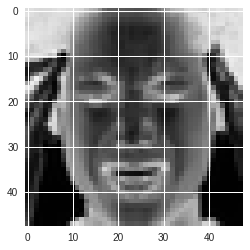

In [51]:
vgg_train = np.apply_along_axis(VGG_preprocessing, 1, X_train_1)
vgg_test = np.apply_along_axis(VGG_preprocessing, 1, X_test_1)
vgg_valid = np.apply_along_axis(VGG_preprocessing, 1, X_valid_1)

In [52]:
vgg_train.shape

(57418, 48, 48, 3)

In [0]:
def Model5():
    vgg = VGG16(include_top=False, input_shape=(48,48,3), weights='imagenet')
    k = Flatten()(vgg.output)
    k = Dense(256, activation='relu')(k)
    k = Dropout(0.2)(k)
    k = Dense(128, activation='relu')(k)
    k = Dropout(0.2)(k)
    k = Dense(64)(k)

    pred = Dense(7, activation='softmax')(k)
    model = Model(input=vgg.input, output=pred)
    return model

In [54]:
model5 = Model5()

58892288/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [55]:
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [0]:
lr_reducer5 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard5 = TensorBoard(log_dir='./logs')
early_stopper5 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer5 = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model5.compile(loss=categorical_crossentropy,
              optimizer=Adamax(),
              metrics=['accuracy'])

In [59]:
model5.fit(vgg_train,Y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(vgg_valid, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer5, tensorboard5, early_stopper5, checkpointer5])

Train on 57418 samples, validate on 3589 samples
Epoch 1/100
57418/57418 [==============================] - 105s 2ms/step - loss: 0.9276 - acc: 0.6572 - val_loss: 1.0209 - val_acc: 0.6102

Epoch 00001: val_loss improved from inf to 1.02088, saving model to /drive
Epoch 2/100
12032/57418 [=====>........................] - ETA: 1:21 - loss: 0.8316 - acc: 0.6999

57418/57418 [==============================] - 105s 2ms/step - loss: 0.8362 - acc: 0.6937 - val_loss: 1.0041 - val_acc: 0.6272

Epoch 00002: val_loss improved from 1.02088 to 1.00408, saving model to /drive
Epoch 3/100
29184/57418 [==============>...............] - ETA: 50s - loss: 0.7316 - acc: 0.7343

57418/57418 [==============================] - 105s 2ms/step - loss: 0.7421 - acc: 0.7314 - val_loss: 0.9972 - val_acc: 0.6442

Epoch 00003: val_loss improved from 1.00408 to 0.99718, saving model to /drive
Epoch 4/100
34048/57418 [================>.............] - ETA: 42s - loss: 0.6321 - acc: 0.7753

57418/57418 [==============================] - 105s 2ms/step - loss: 0.6442 - acc: 0.7730 - val_loss: 1.0956 - val_acc: 0.6222

Epoch 00004: val_loss did not improve from 0.99718
Epoch 5/100
39168/57418 [===================>..........] - ETA: 32s - loss: 0.5445 - acc: 0.8087

57418/57418 [==============================] - 106s 2ms/step - loss: 0.5515 - acc: 0.8050 - val_loss: 1.0645 - val_acc: 0.6481

Epoch 00005: val_loss did not improve from 0.99718
Epoch 6/100
40704/57418 [====================>.........] - ETA: 30s - loss: 0.4451 - acc: 0.8473

57418/57418 [==============================] - 106s 2ms/step - loss: 0.4577 - acc: 0.8413 - val_loss: 1.1697 - val_acc: 0.6431

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0018000000854954123.

Epoch 00006: val_loss did not improve from 0.99718
Epoch 7/100
31744/57418 [===============>..............] - ETA: 46s - loss: 0.3454 - acc: 0.8820

57418/57418 [==============================] - 105s 2ms/step - loss: 0.3494 - acc: 0.8803 - val_loss: 1.2672 - val_acc: 0.6308

Epoch 00007: val_loss did not improve from 0.99718
Epoch 8/100
38400/57418 [===================>..........] - ETA: 34s - loss: 0.2751 - acc: 0.9084

57418/57418 [==============================] - 105s 2ms/step - loss: 0.2804 - acc: 0.9065 - val_loss: 1.4211 - val_acc: 0.6459

Epoch 00008: val_loss did not improve from 0.99718
Epoch 9/100
40448/57418 [====================>.........] - ETA: 30s - loss: 0.2237 - acc: 0.9269

57418/57418 [==============================] - 105s 2ms/step - loss: 0.2286 - acc: 0.9252 - val_loss: 1.4638 - val_acc: 0.6383

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0016200000769458712.

Epoch 00009: val_loss did not improve from 0.99718
Epoch 10/100
31616/57418 [===============>..............] - ETA: 46s - loss: 0.1670 - acc: 0.9474

57418/57418 [==============================] - 105s 2ms/step - loss: 0.1744 - acc: 0.9447 - val_loss: 1.6003 - val_acc: 0.6595

Epoch 00010: val_loss did not improve from 0.99718
Epoch 11/100
38272/57418 [==================>...........] - ETA: 34s - loss: 0.1378 - acc: 0.9568

57418/57418 [==============================] - 105s 2ms/step - loss: 0.1420 - acc: 0.9550 - val_loss: 1.6608 - val_acc: 0.6553

Epoch 00011: val_loss did not improve from 0.99718
Epoch 00011: early stopping


In [60]:
model5.evaluate(vgg_test, Y_test)

3589/3589 [==============================] - 3s 941us/step


[1.7430417702768666, 0.6433546949176943]

In [0]:
model5.save_weights('drive/face_expr_model5.h5')

Since the training error is much larger than the dev error .. this proves high variance thus overfitting . This is common when needed features are less and model is too big . So to solve that we will try data augmentation"

In [66]:
model5_n = Model5()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [0]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()
train_generator = gen.flow(vgg_train, Y_train, batch_size=64)
 
model5_n.compile(loss='categorical_crossentropy'
, optimizer=Adamax(lr=0.0005)
, metrics=['accuracy']
)
 

In [0]:
model5_n.fit_generator(train_generator, steps_per_epoch=50, epochs=60)

Epoch 1/60
50/50 [==============================] - 8s 150ms/step - loss: 1.1295 - acc: 0.5772
Epoch 2/60
50/50 [==============================] - 8s 150ms/step - loss: 1.1209 - acc: 0.5747
Epoch 3/60
50/50 [==============================] - 7s 150ms/step - loss: 1.1314 - acc: 0.5844
Epoch 4/60
50/50 [==============================] - 8s 150ms/step - loss: 1.0830 - acc: 0.5925
Epoch 5/60
50/50 [==============================] - 8s 151ms/step - loss: 1.0916 - acc: 0.6034
Epoch 6/60
50/50 [==============================] - 8s 150ms/step - loss: 1.1099 - acc: 0.5900
Epoch 7/60


50/50 [==============================] - 7s 150ms/step - loss: 1.0682 - acc: 0.6075
Epoch 8/60
50/50 [==============================] - 8s 150ms/step - loss: 1.0757 - acc: 0.5994
Epoch 9/60
50/50 [==============================] - 8s 150ms/step - loss: 1.0564 - acc: 0.6053
Epoch 10/60
50/50 [==============================] - 8s 150ms/step - loss: 1.0543 - acc: 0.6025
Epoch 11/60
50/50 [==============================] - 7s 150ms/step - loss: 1.0766 - acc: 0.5934
Epoch 12/60
50/50 [==============================] - 8s 150ms/step - loss: 1.0268 - acc: 0.6175
Epoch 13/60
 5/50 [==>...........................] - ETA: 6s - loss: 1.0498 - acc: 0.6031

50/50 [==============================] - 7s 149ms/step - loss: 1.0415 - acc: 0.6188
Epoch 14/60
50/50 [==============================] - 7s 150ms/step - loss: 1.0059 - acc: 0.6216
Epoch 15/60
50/50 [==============================] - 7s 149ms/step - loss: 1.0377 - acc: 0.6166
Epoch 16/60
50/50 [==============================] - 7s 150ms/step - loss: 1.0232 - acc: 0.6200
Epoch 17/60
50/50 [==============================] - 7s 150ms/step - loss: 0.9993 - acc: 0.6328
Epoch 18/60
50/50 [==============================] - 8s 150ms/step - loss: 1.0523 - acc: 0.6159
Epoch 19/60
 4/50 [=>............................] - ETA: 6s - loss: 1.0233 - acc: 0.6250

50/50 [==============================] - 8s 151ms/step - loss: 0.9567 - acc: 0.6416
Epoch 20/60
50/50 [==============================] - 8s 151ms/step - loss: 0.9342 - acc: 0.6494
Epoch 21/60
50/50 [==============================] - 7s 149ms/step - loss: 0.9099 - acc: 0.6616
Epoch 22/60
50/50 [==============================] - 8s 150ms/step - loss: 0.9040 - acc: 0.6672
Epoch 23/60
50/50 [==============================] - 8s 151ms/step - loss: 0.9286 - acc: 0.6559
Epoch 24/60
50/50 [==============================] - 8s 151ms/step - loss: 0.9710 - acc: 0.6475
Epoch 25/60
 4/50 [=>............................] - ETA: 6s - loss: 0.9917 - acc: 0.6406

50/50 [==============================] - 7s 150ms/step - loss: 0.9328 - acc: 0.6603
Epoch 26/60
50/50 [==============================] - 8s 150ms/step - loss: 0.8776 - acc: 0.6734
Epoch 27/60
50/50 [==============================] - 8s 150ms/step - loss: 0.9114 - acc: 0.6594
Epoch 28/60
50/50 [==============================] - 8s 151ms/step - loss: 0.9236 - acc: 0.6550
Epoch 29/60
50/50 [==============================] - 8s 150ms/step - loss: 0.9326 - acc: 0.6566
Epoch 30/60
50/50 [==============================] - 7s 149ms/step - loss: 0.9501 - acc: 0.6644
Epoch 31/60
 4/50 [=>............................] - ETA: 7s - loss: 0.7811 - acc: 0.7070

50/50 [==============================] - 7s 150ms/step - loss: 0.9097 - acc: 0.6600
Epoch 32/60
50/50 [==============================] - 7s 149ms/step - loss: 0.9012 - acc: 0.6706
Epoch 33/60
20/50 [===========>..................] - ETA: 4s - loss: 0.9524 - acc: 0.6531